# 4. Identification based on user movements and traffic (normalized height)

In [1]:
# import numpy for math calculations
import numpy as np

# import pandas for data (csv) manipulation
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt

import sys  
sys.path.insert(1, '../src/')

from train_model import ClassifierEvaluator
from visualize import VisualizationUtils
import seaborn as sns
# import shap for ai explainability
import shap

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import tree

# import warnings to hide the unnessairy warniings
import warnings
warnings.filterwarnings('ignore')

In [2]:
mov_slow = pd.read_csv('../data/processed/movement_slow_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
mov_fast = pd.read_csv('../data/processed/movement_fast_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
traffic_slow = pd.read_csv('../data/processed/traffic_slow_stat_cleaned.csv', index_col=0).fillna(0)
traffic_fast = pd.read_csv('../data/processed/traffic_fast_stat_cleaned.csv', index_col=0).fillna(0)

# Drop height
for col in mov_fast.columns.values:
    if "PosY" in col and "Accel" not in col and "Velocity" not in col:
        print(col)
        for id in range(60):
            #print(id, col, mov_fast.loc[mov_fast['ID'] == id][col])
            print(id, col, np.mean(mov_fast.loc[mov_fast['ID'] == id,col]), np.max(mov_fast.loc[mov_fast['ID'] == id,col]), np.min(mov_fast.loc[mov_fast['ID'] == id,col]))
            mov_fast.loc[mov_fast['ID'] == id,col] = mov_fast.loc[mov_fast['ID'] == id,col] / np.mean(mov_fast.loc[mov_fast['ID'] == id,col])
            print(id, col, np.mean(mov_fast.loc[mov_fast['ID'] == id,col]), np.max(mov_fast.loc[mov_fast['ID'] == id,col]), np.min(mov_fast.loc[mov_fast['ID'] == id,col]))
            mov_slow.loc[mov_slow['ID'] == id,col] = mov_slow.loc[mov_slow['ID'] == id,col] / np.mean(mov_fast.loc[mov_fast['ID'] == id,col])

# Concatenate movement and traffic data for both slow and fast datasets
slow_combined = pd.concat([mov_slow, traffic_slow.drop(columns=['time_interval','ID'])], axis=1).dropna()
fast_combined = pd.concat([mov_fast, traffic_fast.drop(columns=['time_interval','ID'])], axis=1).dropna()
unique_minutes = list(range(1,11))

HeadPosY_25%
0 HeadPosY_25% 0.7134620286105323 0.7278551096508605 0.6570334403533158
0 HeadPosY_25% 0.9999999999999999 1.0201735768171976 0.9209087716032888
1 HeadPosY_25% 0.7788999002622312 0.8124401626932196 0.2526097097609505
1 HeadPosY_25% 0.9999999999999998 1.0430610691048958 0.3243160124630966
2 HeadPosY_25% 0.9066900340050817 0.9214591842635648 0.7479711538667484
2 HeadPosY_25% 1.0000000000000002 1.0162890841462588 0.824946923220021
3 HeadPosY_25% 0.8121922818530807 0.8303501245472713 0.7458421772961998
3 HeadPosY_25% 1.0 1.0223565811937563 0.918307393409972
4 HeadPosY_25% 0.8161531278178419 0.8245928921311398 0.7965606533430714
4 HeadPosY_25% 1.0 1.0103409078831365 0.9759941194771192
5 HeadPosY_25% 0.8564253755159127 0.9103195392500604 0.7888929107650393
5 HeadPosY_25% 0.9999999999999999 1.0629291999920971 0.9211461188779096
6 HeadPosY_25% 0.8777812166008767 0.8872263547594619 0.8320635865758819
6 HeadPosY_25% 1.0 1.0107602418233106 0.9479168280656176
7 HeadPosY_25% 0.857940040

### 4.1. Training On Cooking Similator

In [3]:
evaluator = ClassifierEvaluator()
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(slow_combined, fast_combined, id_range=range(0,30), train_minutes=8, test_minutes=2)

Size of the training set:  (1437, 490)
Size of the slow testing set:  (360, 490)
Size of the fast training set:  (1440, 490)
Size of the fast testing set:  (360, 490)


In [4]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

 83%|██████████████████████████████████████████████████████████▎           | 5/6 [00:20<00:05,  5.94s/it]/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:39<00:00,  6.65s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
2,QuadraticDiscriminantAnalysis,1.000000,0.086111,0.027778,1.000000,0.087600,0.028780,1.000000,0.096917,0.032347,1.000000,0.086111,0.027778,0.000000,32.939894,35.042441
3,LogisticRegression,0.983994,0.802778,0.052778,0.983929,0.790509,0.036397,0.984351,0.798653,0.099660,0.984028,0.802778,0.052778,0.252338,0.714955,7.836561
4,LGBMClassifier,1.000000,0.850000,0.111111,1.000000,0.835203,0.048151,1.000000,0.863659,0.032429,1.000000,0.850000,0.111111,0.000019,0.537050,5.880474
5,VotingClassifier,1.000000,0.852778,0.091667,1.000000,0.837705,0.052337,1.000000,0.850576,0.047485,1.000000,0.852778,0.091667,0.065405,0.803918,4.371396
0,ExtraTreesClassifier,1.000000,0.872222,0.122222,1.000000,0.859616,0.064123,1.000000,0.872780,0.059779,1.000000,0.872222,0.122222,0.000000,0.819573,7.438089
1,RandomForestClassifier,1.000000,0.883333,0.111111,1.000000,0.873000,0.053085,1.000000,0.895526,0.041143,1.000000,0.883333,0.111111,0.124743,0.770832,12.183576


In [5]:
explainer = shap.TreeExplainer(best_model_slow)
shap_values_slow = explainer.shap_values(X_test)

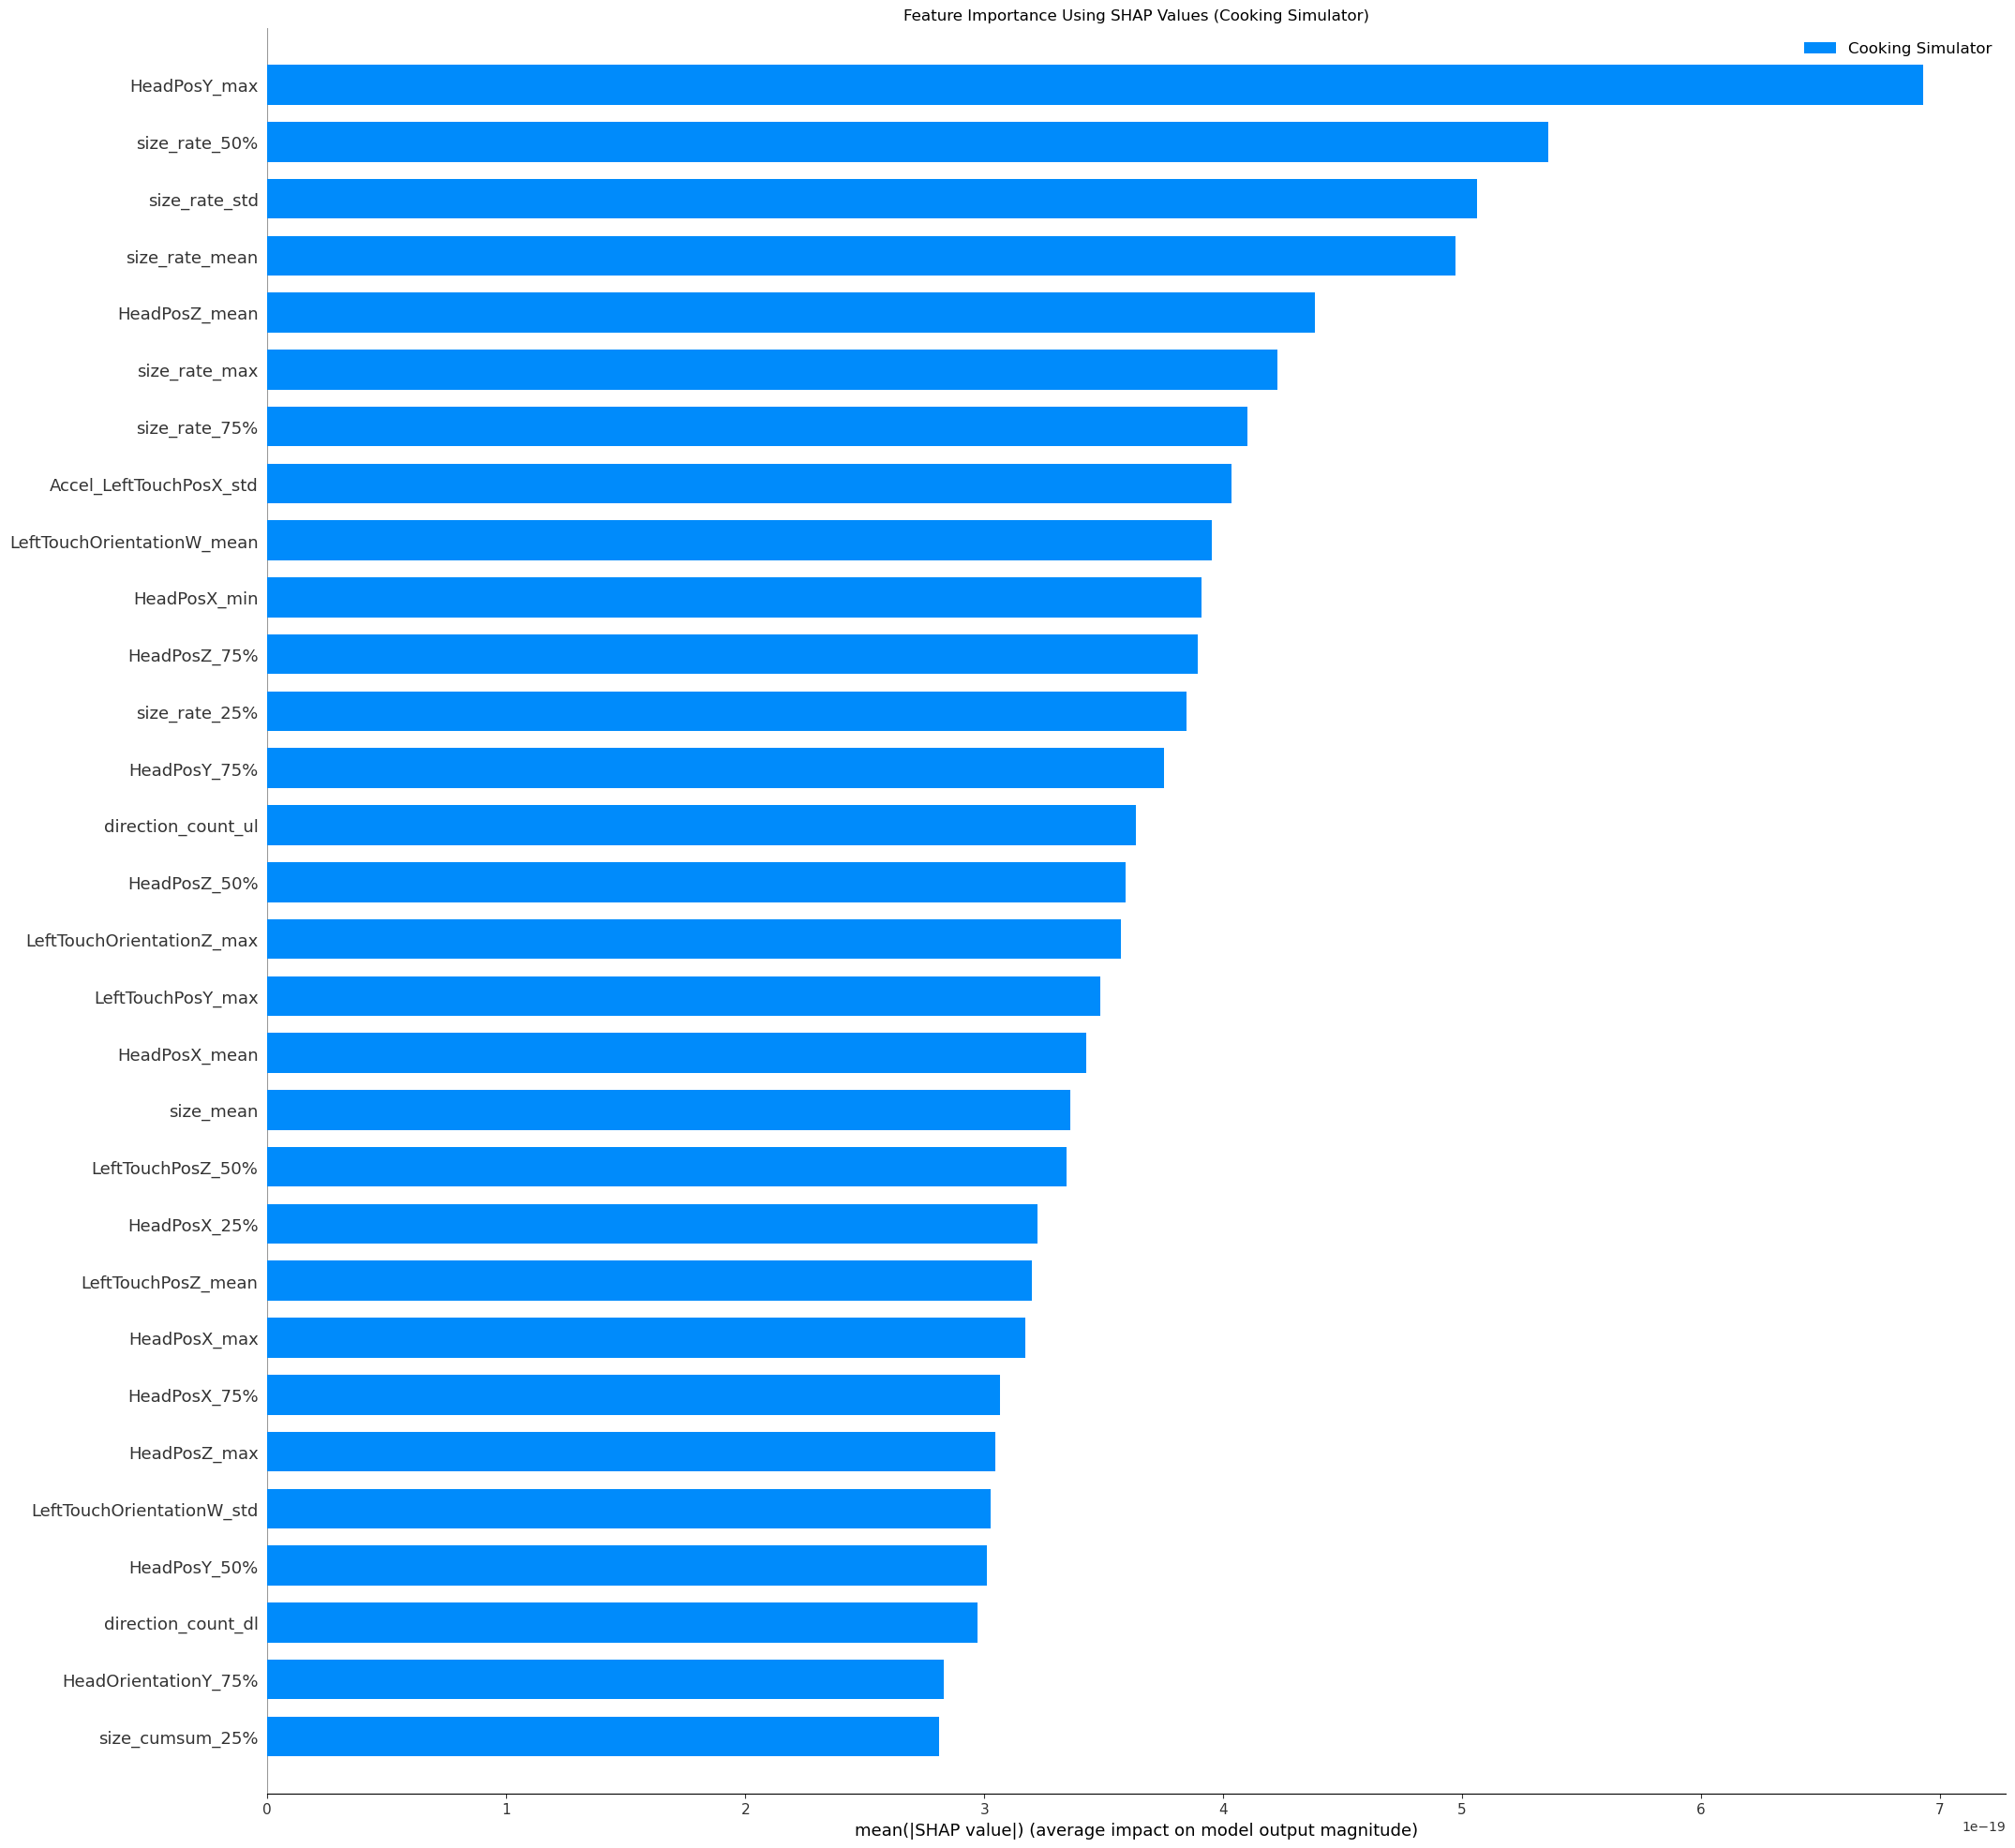

In [6]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow, axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (Cooking Simulator)",
                          class_names=['Cooking Simulator'])

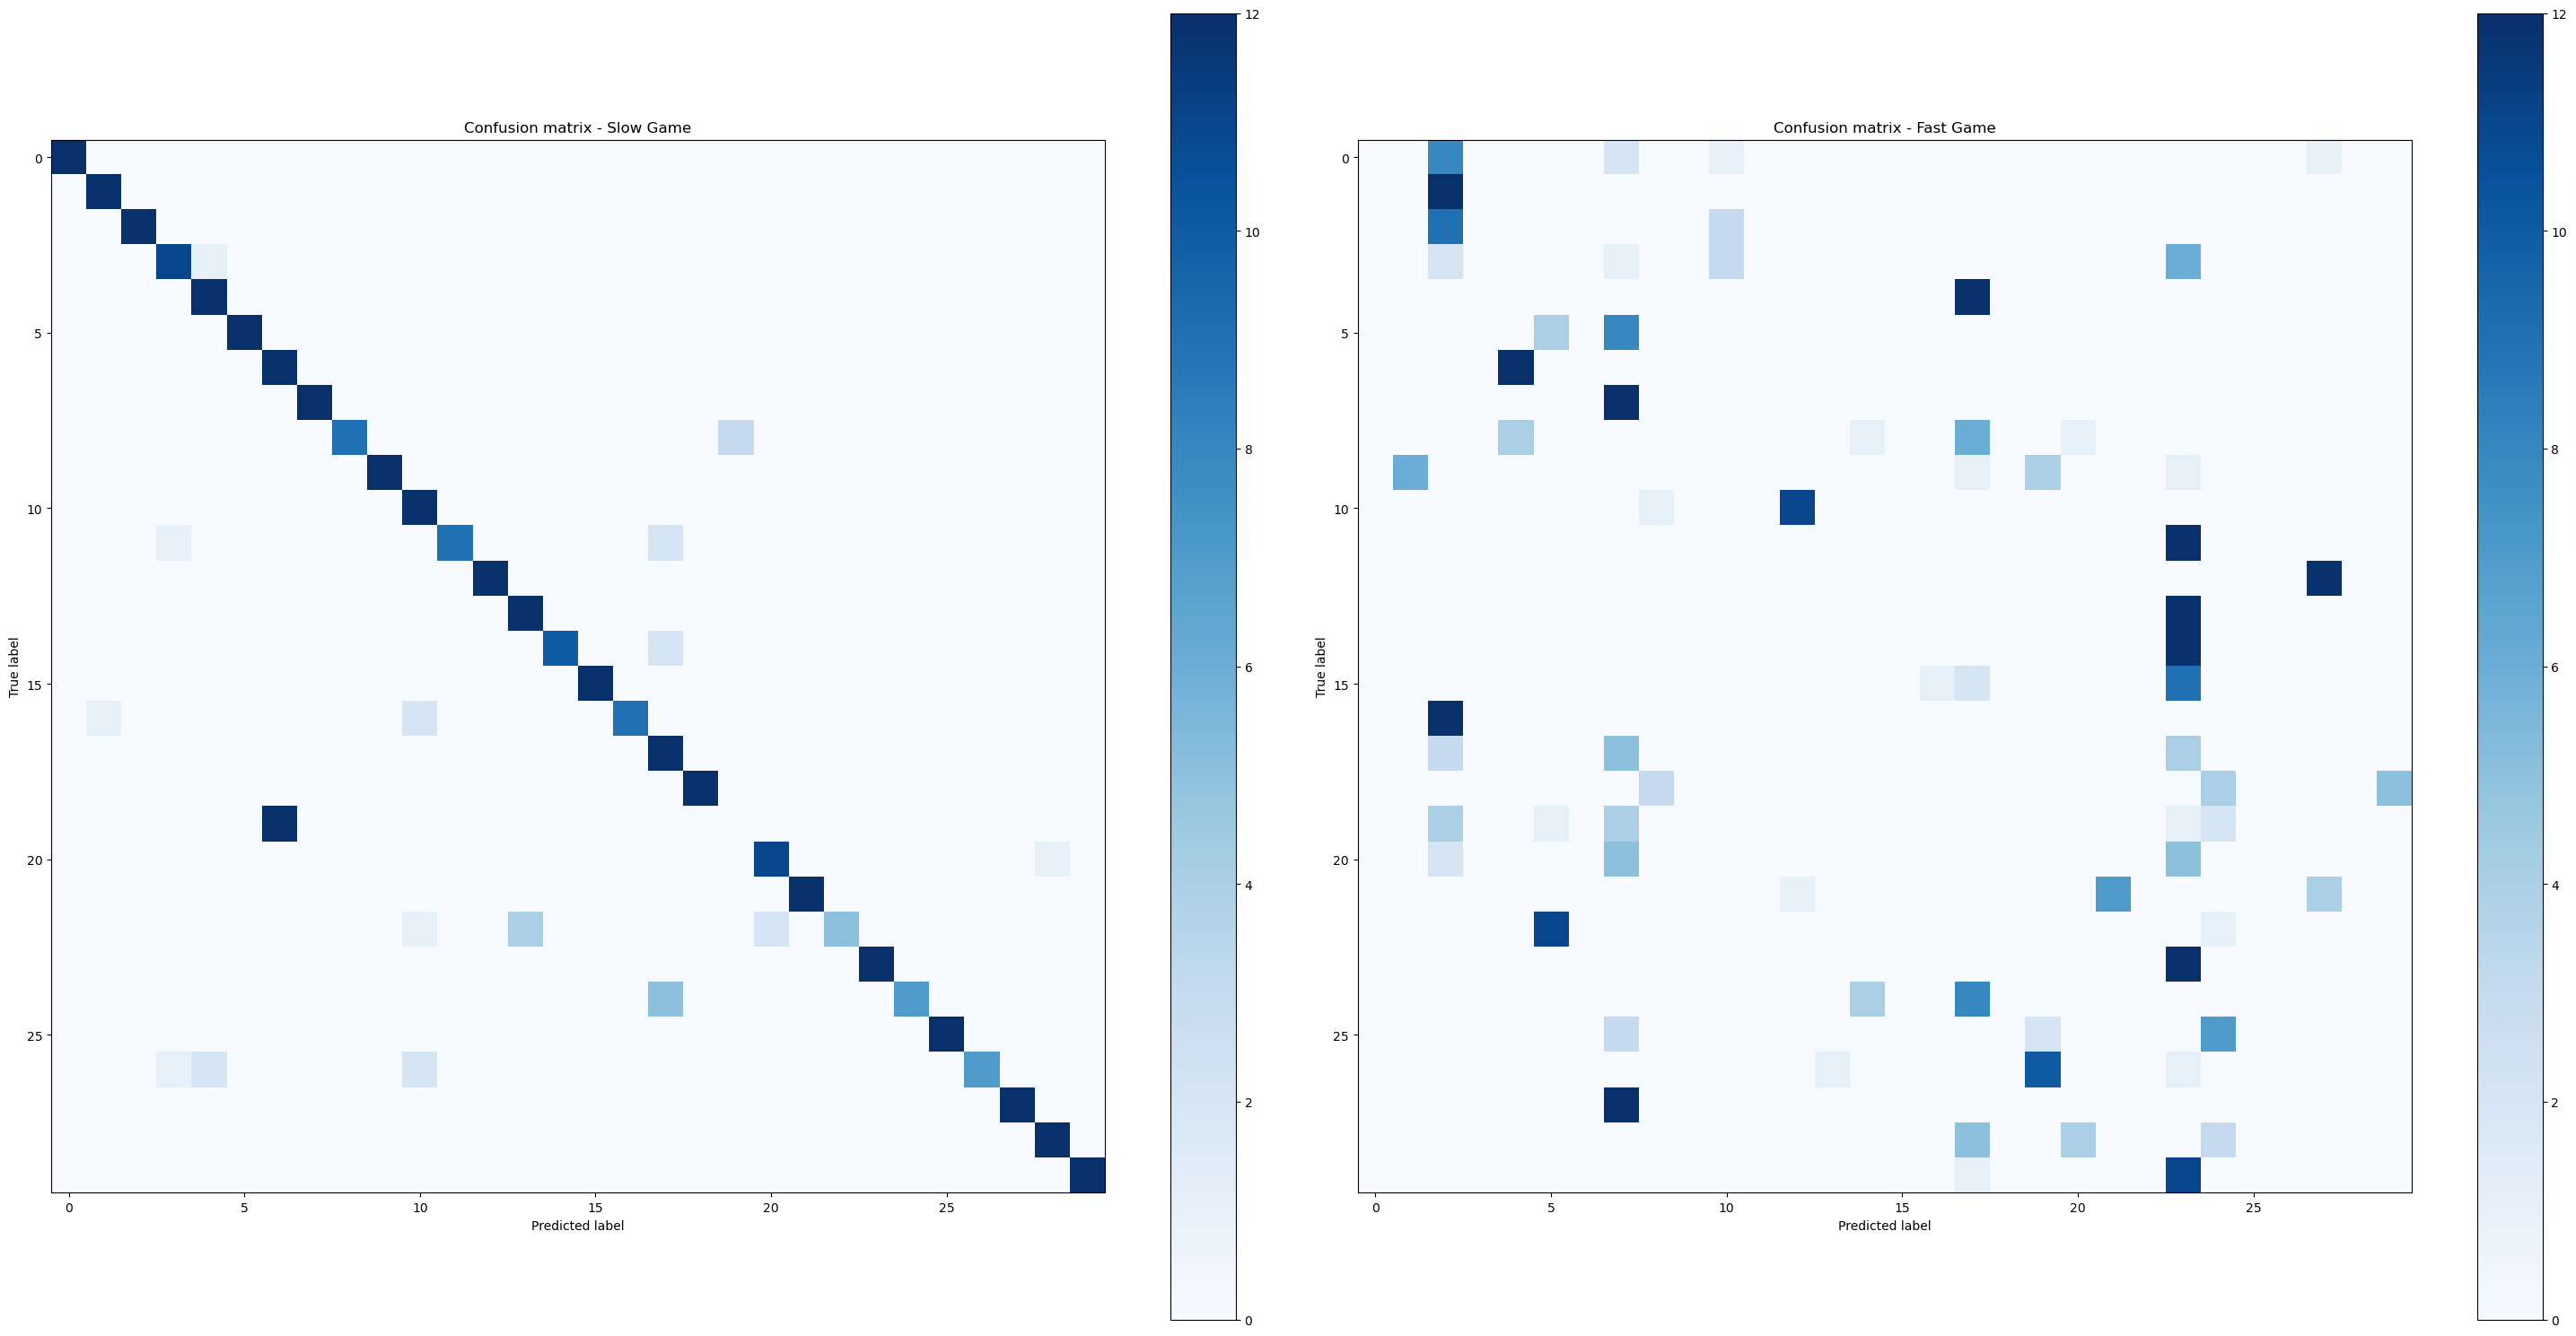

In [7]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

In [8]:
# Find the participant with the highest misclassification
misclassified_participant = np.argmax(np.sum(cm_slow, axis=1) - np.diag(cm_slow))
confused_with = np.argmax(cm_slow[misclassified_participant, :])
print(f"Participant {misclassified_participant} is most often misclassified as {confused_with}")

Participant 19 is most often misclassified as 6


In [9]:
# Compare features between the misclassified participant and the one they're confused with
features_to_compare = [col for col in mov_slow.columns if col != 'ID']
misclassified_data = mov_slow[mov_slow['ID'] == misclassified_participant][features_to_compare]
confused_with_data = mov_slow[mov_slow['ID'] == confused_with][features_to_compare]

In [10]:
# Calculate feature similarities
similarities = 1 - np.abs(misclassified_data.mean() - confused_with_data.mean()) / (misclassified_data.mean() + confused_with_data.mean())

# Sort features by similarity
most_similar_features = similarities.sort_values(ascending=False)

In [11]:
print("\nTop 10 most similar features:")
print(most_similar_features.head(10))


Top 10 most similar features:
time_interval                  1.000000
Accel_LeftTouchPosY_mean       1.000000
Head_OrientationAccelY_mean    0.999999
Accel_HeadPosX_mean            0.999998
Accel_RightTouchPosZ_mean      0.999998
Accel_HeadPosY_mean            0.999997
Accel_RightTouchPosX_mean      0.999996
Accel_HeadPosZ_mean            0.999996
Accel_LeftTouchPosX_mean       0.999995
Accel_RightTouchPosY_mean      0.999994
dtype: float64


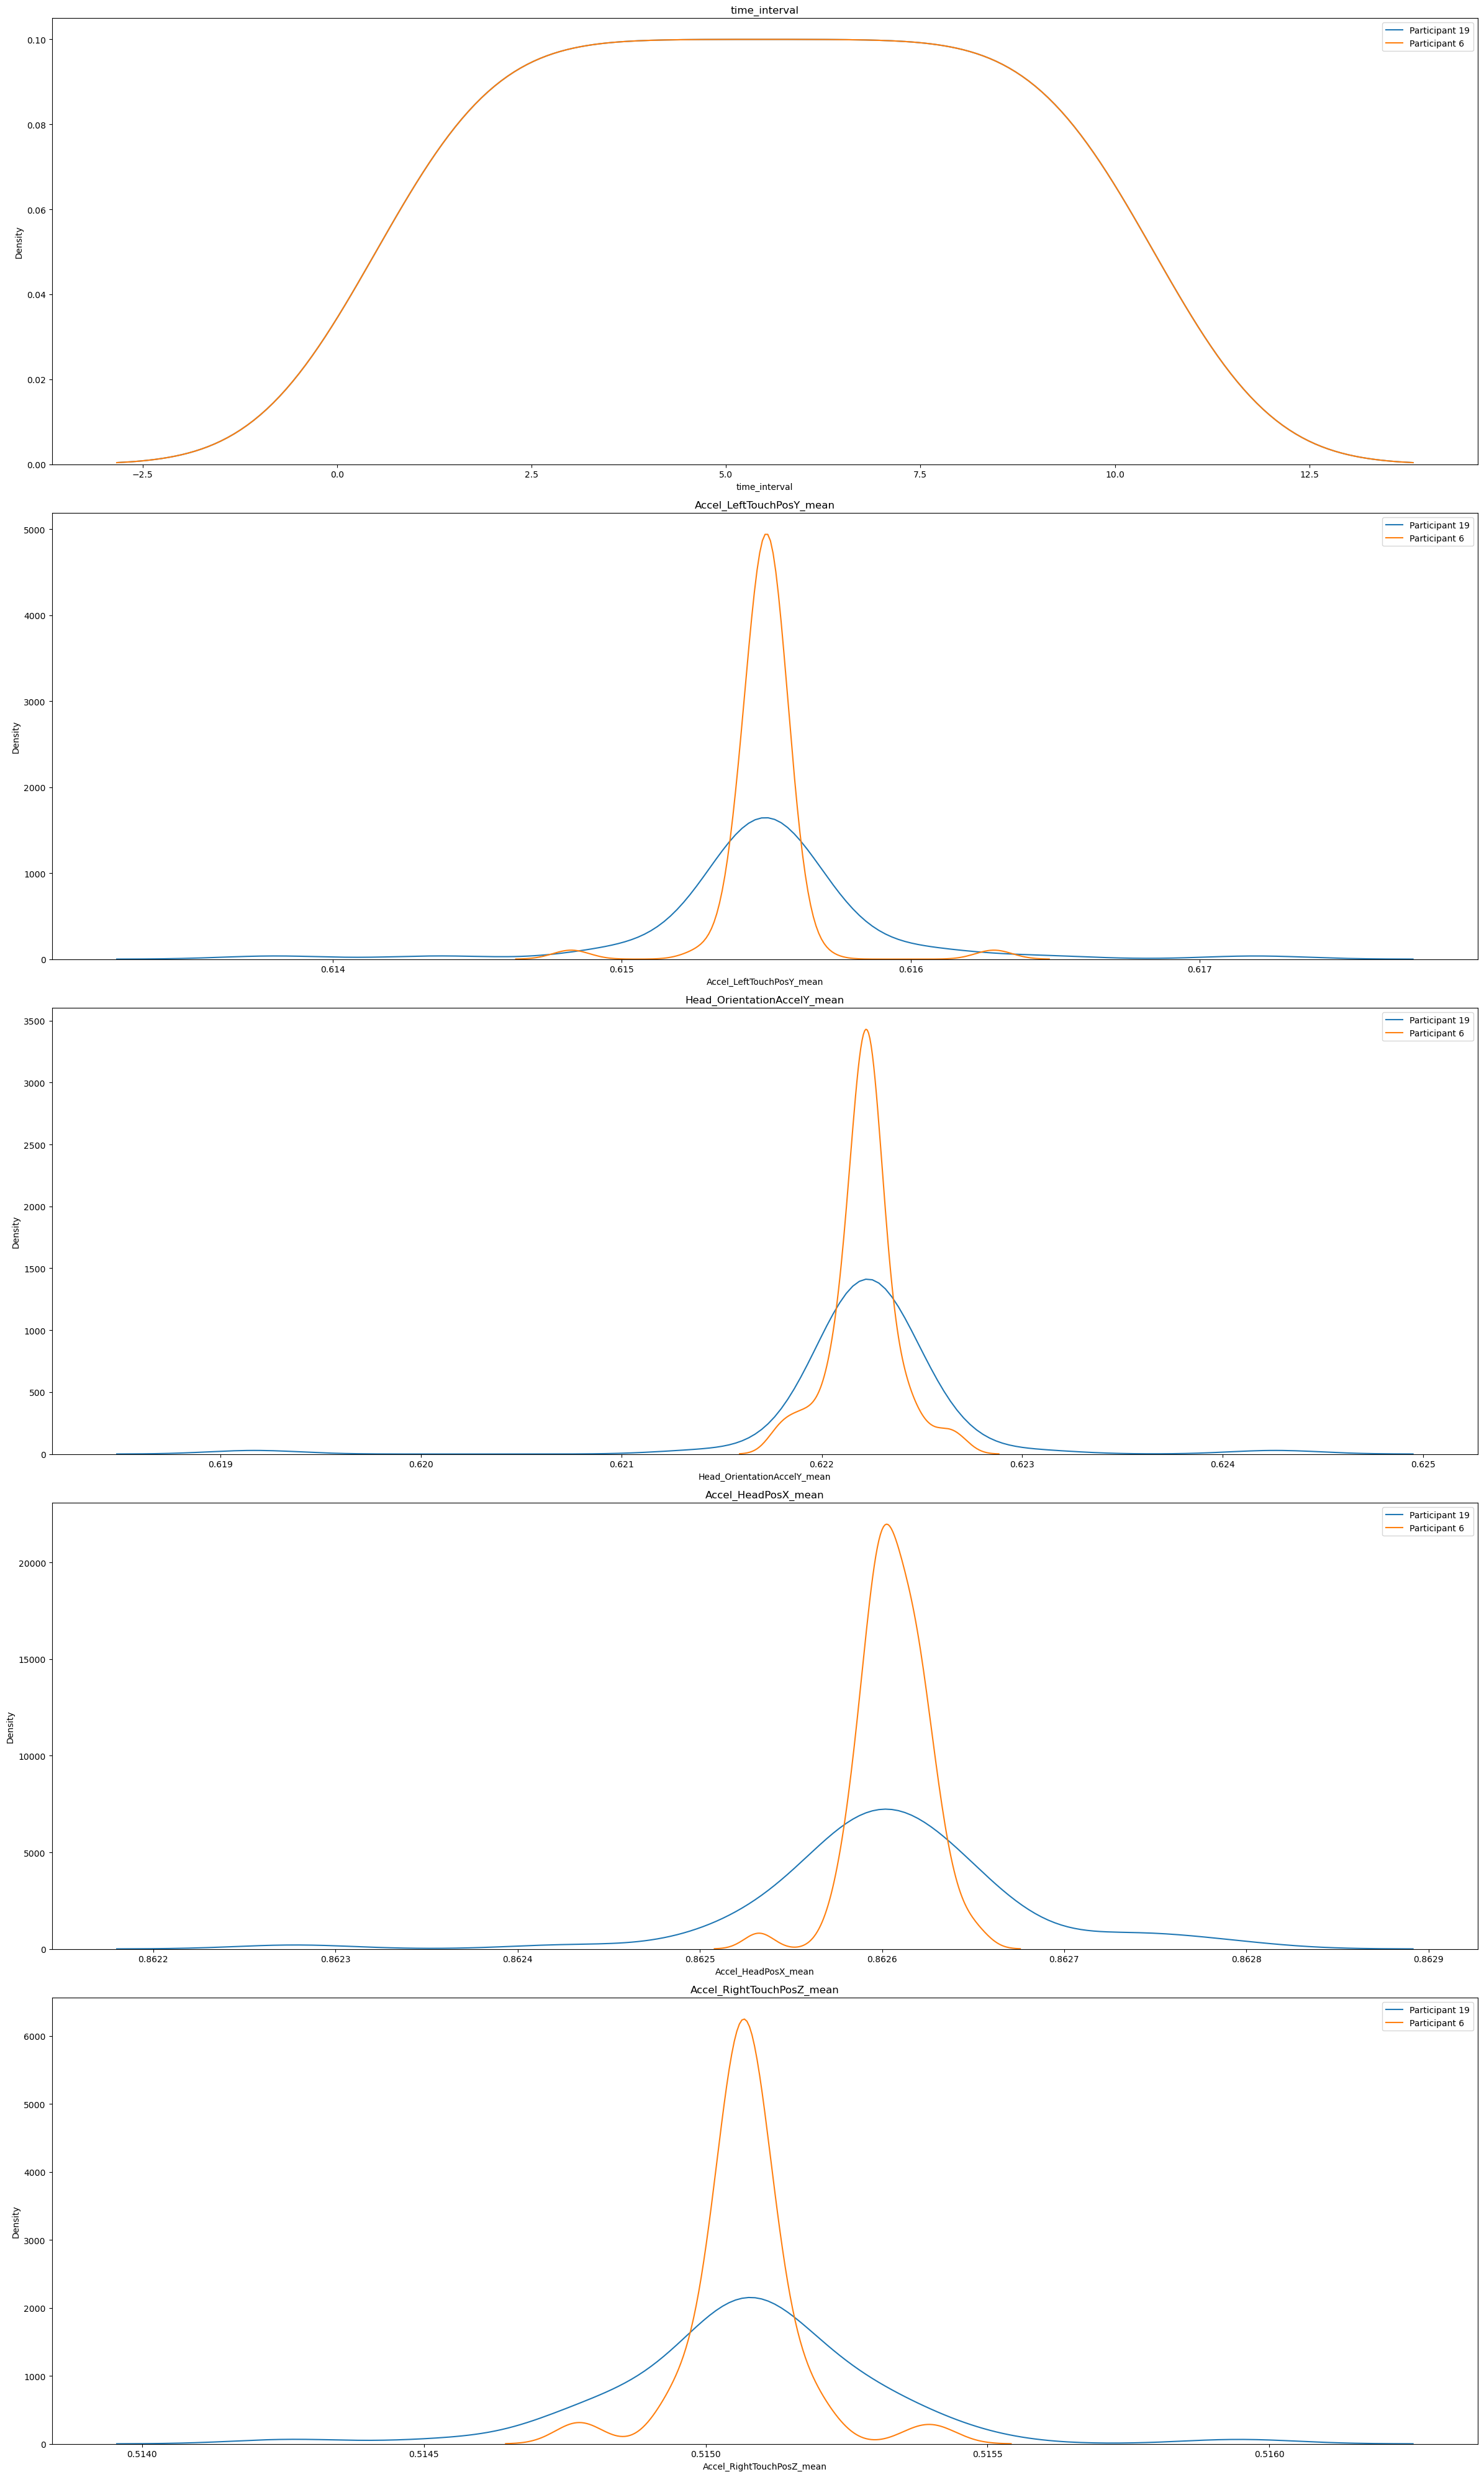

In [12]:
# Visualize feature distributions for top 5 similar features
top_5_features = most_similar_features.head(5).index

fig, axes = plt.subplots(5, 1, figsize=(24, 40))
for i, feature in enumerate(top_5_features):
    sns.kdeplot(data=misclassified_data[feature], ax=axes[i], label=f"Participant {misclassified_participant}")
    sns.kdeplot(data=confused_with_data[feature], ax=axes[i], label=f"Participant {confused_with}")
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [13]:
# Analyze differences in other features
differences = np.abs(misclassified_data.mean() - confused_with_data.mean()) / (misclassified_data.mean() + confused_with_data.mean())
most_different_features = differences.sort_values(ascending=False)

print("\nTop 10 most different features:")
print(most_different_features.head(10))


Top 10 most different features:
LeftTouch_OrientationAccelY_std        0.950256
LeftTouch_OrientationAccelY_max        0.943778
LeftTouch_OrientationVelocityY_max     0.924526
LeftTouch_OrientationVelocityY_std     0.894665
RightTouch_OrientationAccelY_max       0.827080
RightTouch_OrientationAccelY_std       0.816302
Head_OrientationAccelZ_max             0.804402
RightTouch_OrientationVelocityY_max    0.762452
RightTouch_OrientationVelocityY_std    0.736701
LeftTouchOrientationY_std              0.728629
dtype: float64


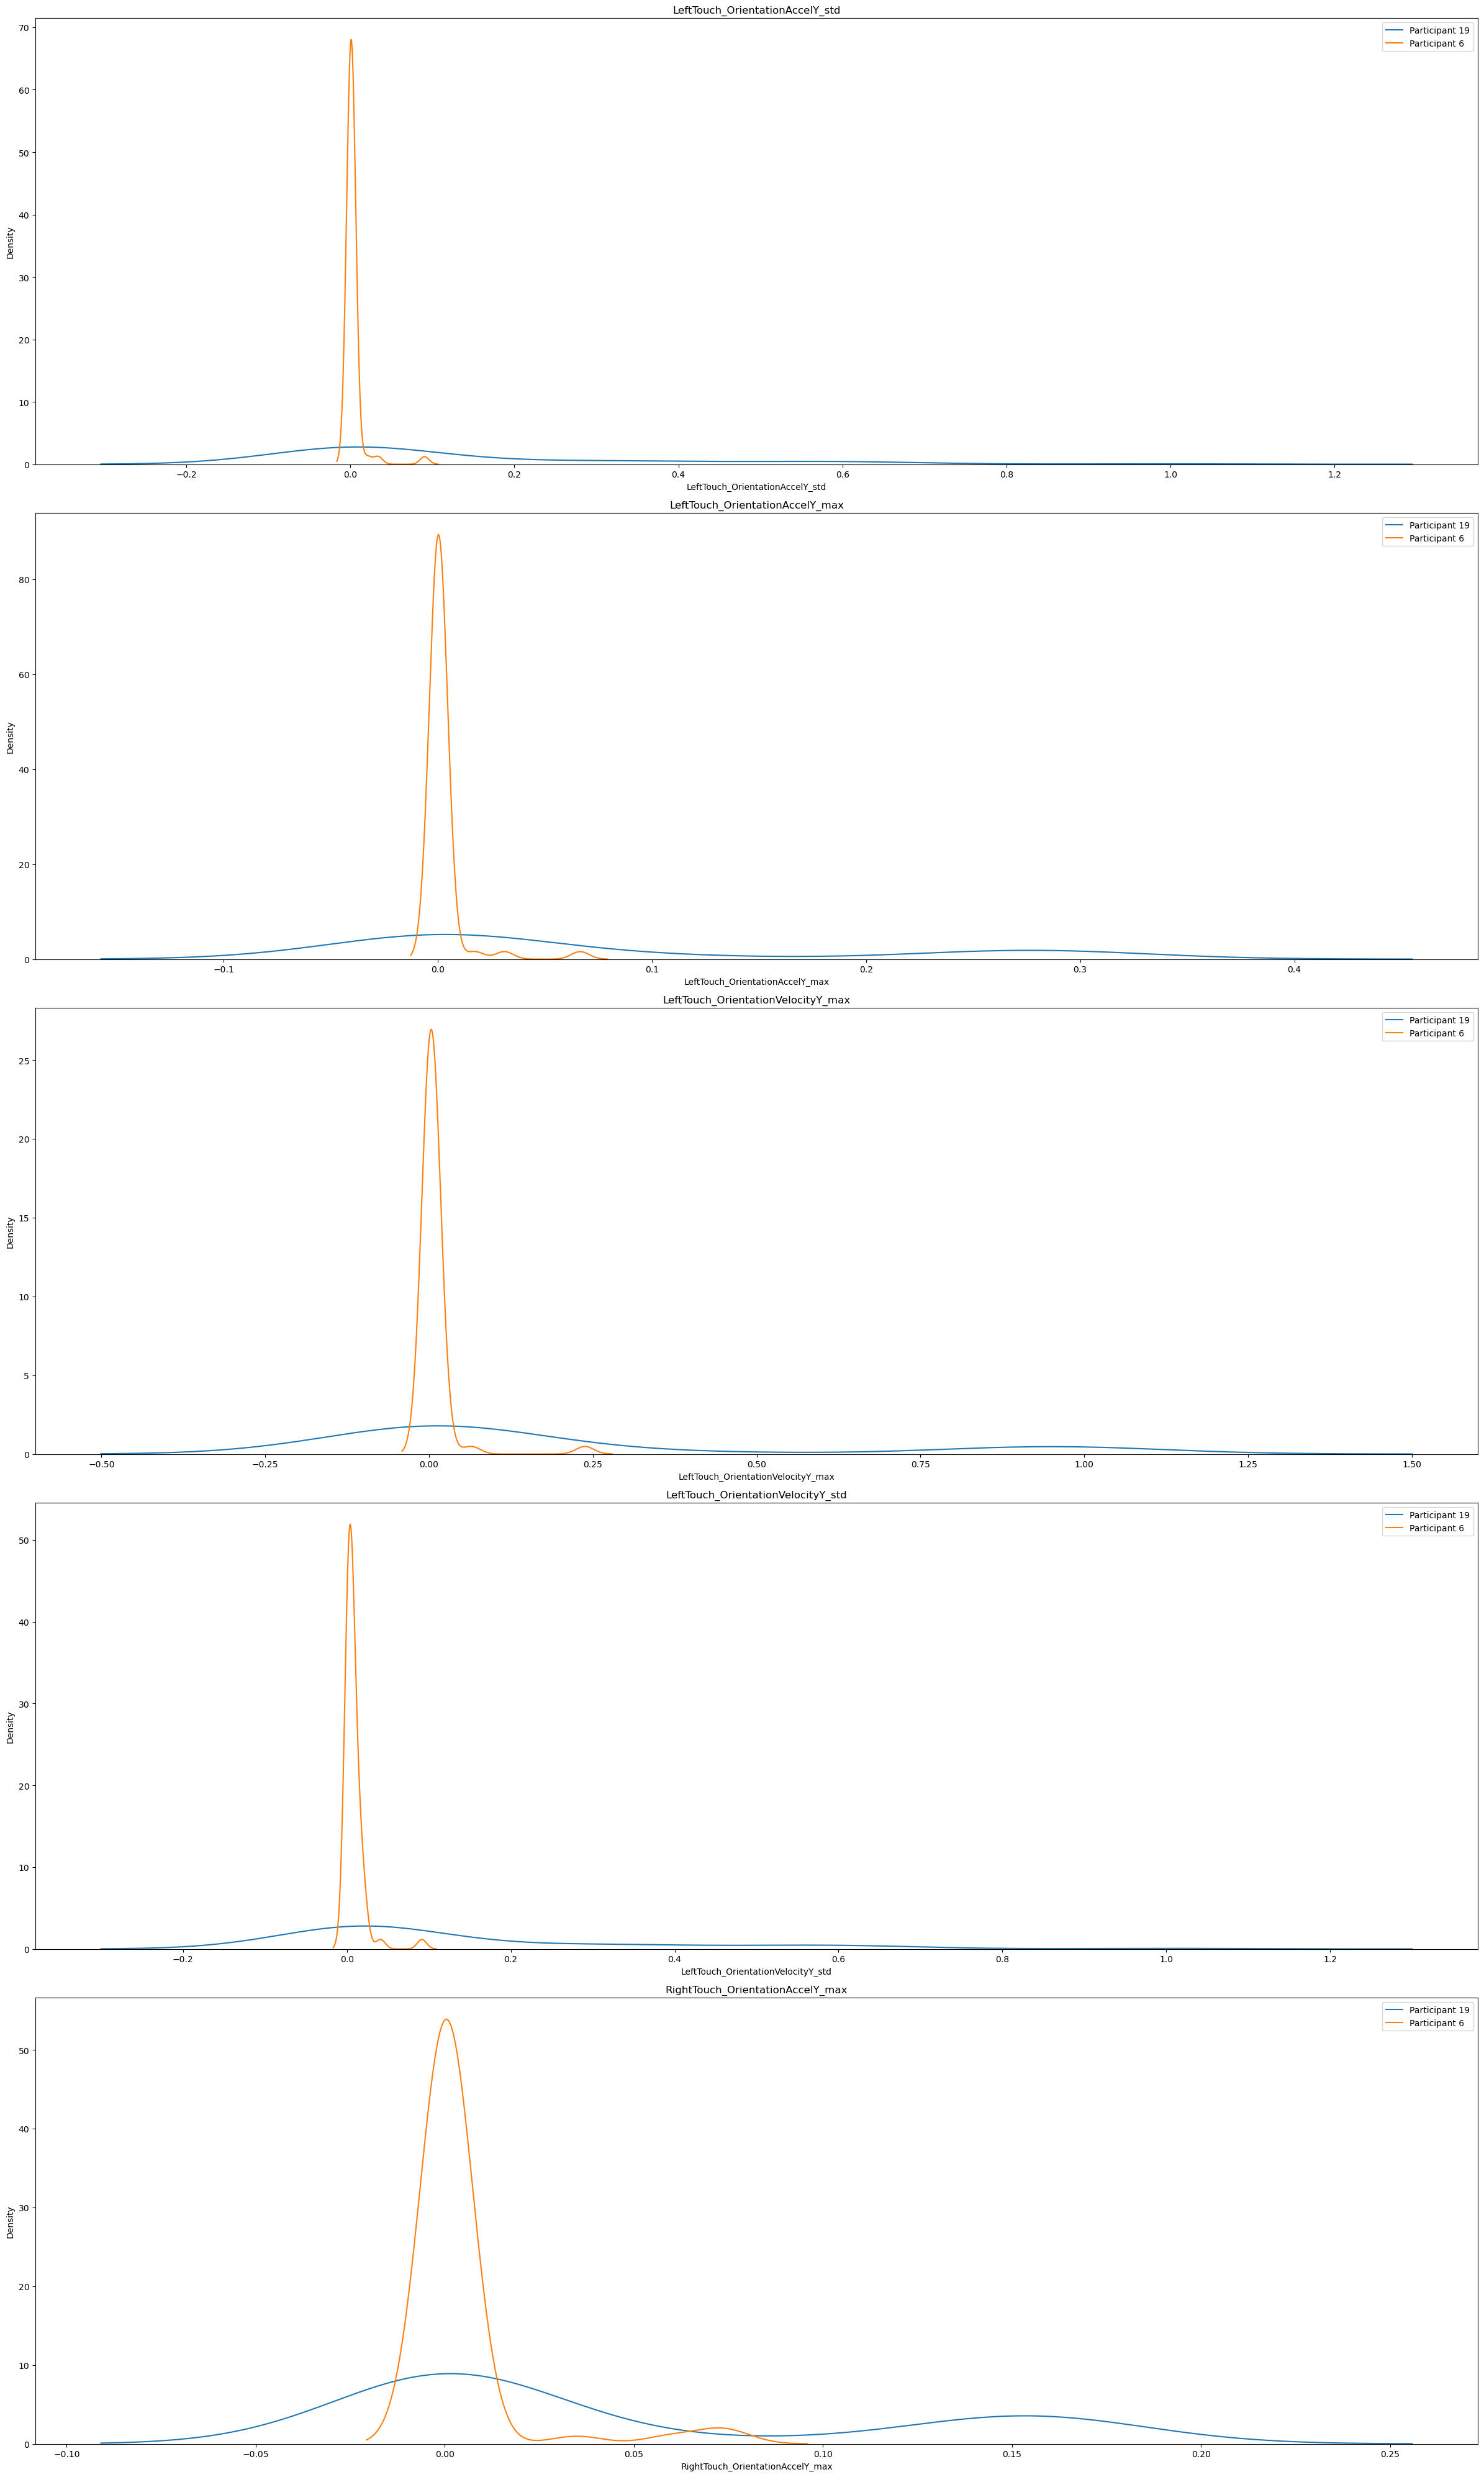

In [14]:
# Visualize feature distributions for top 5 different features
top_5_different_features = most_different_features.head(5).index

fig, axes = plt.subplots(5, 1, figsize=(24, 40))
for i, feature in enumerate(top_5_different_features):
    sns.kdeplot(data=misclassified_data[feature], ax=axes[i], label=f"Participant {misclassified_participant}")
    sns.kdeplot(data=confused_with_data[feature], ax=axes[i], label=f"Participant {confused_with}")
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

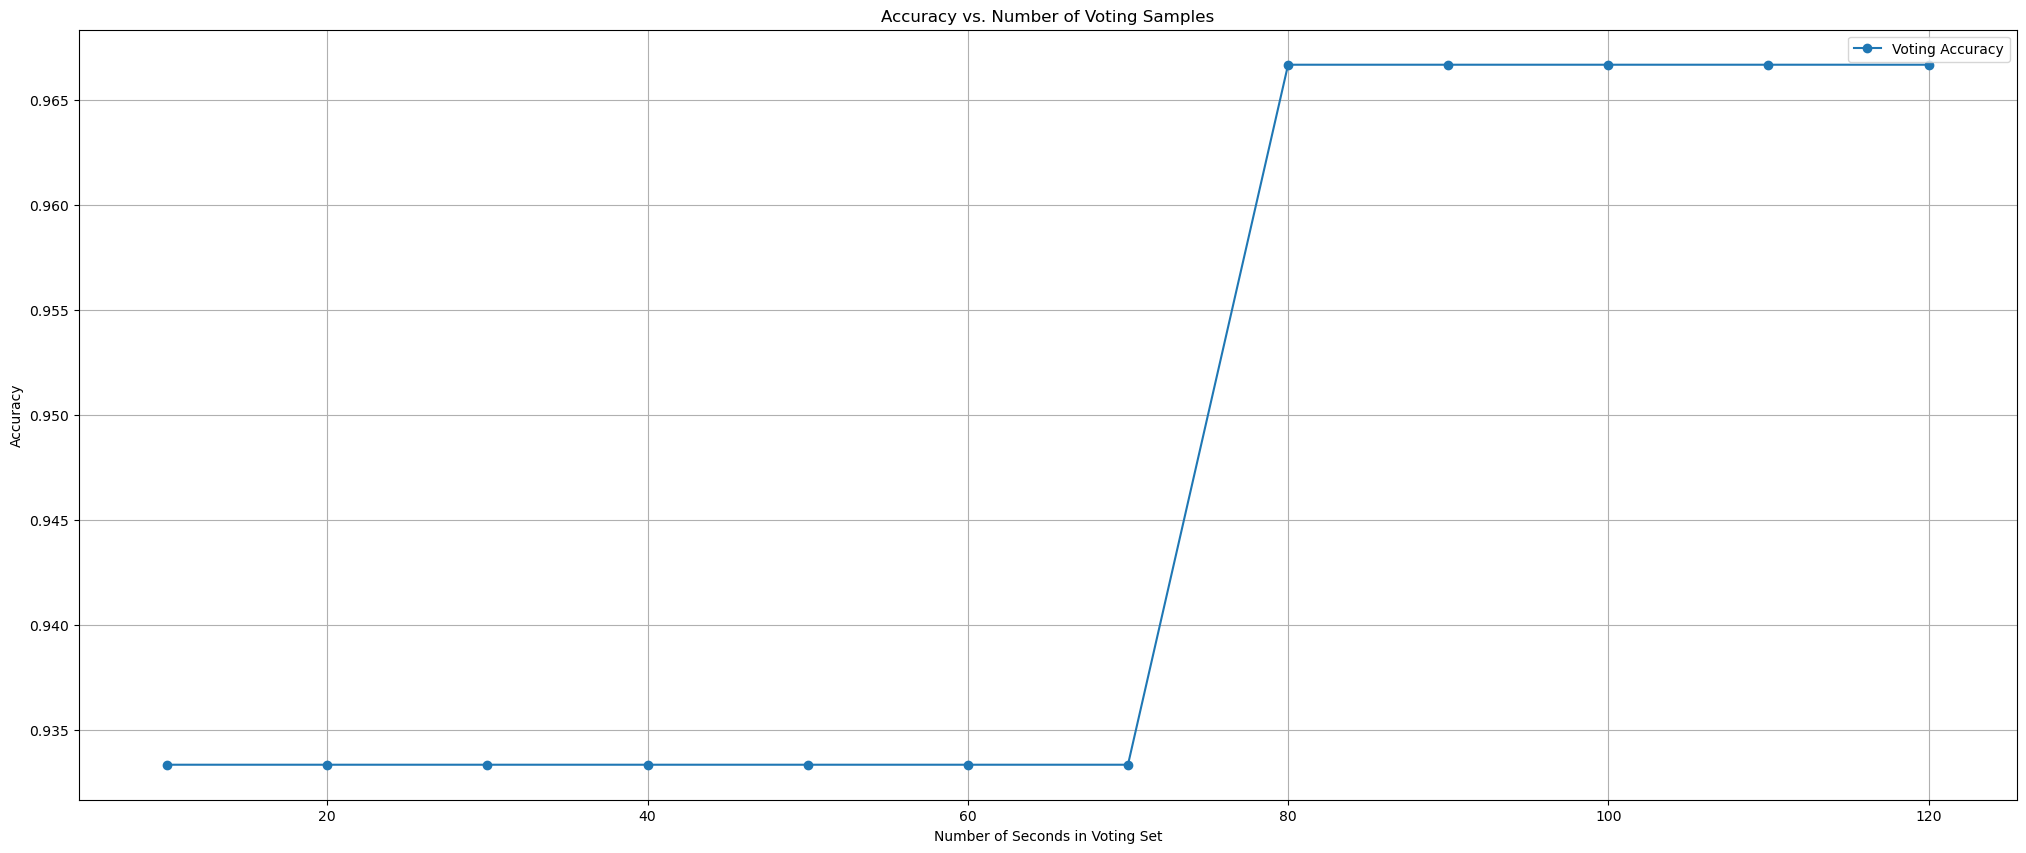


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.933333
1,20,0.933333
2,30,0.933333
3,40,0.933333
4,50,0.933333
5,60,0.933333
6,70,0.933333
7,80,0.966667
8,90,0.966667
9,100,0.966667


In [15]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

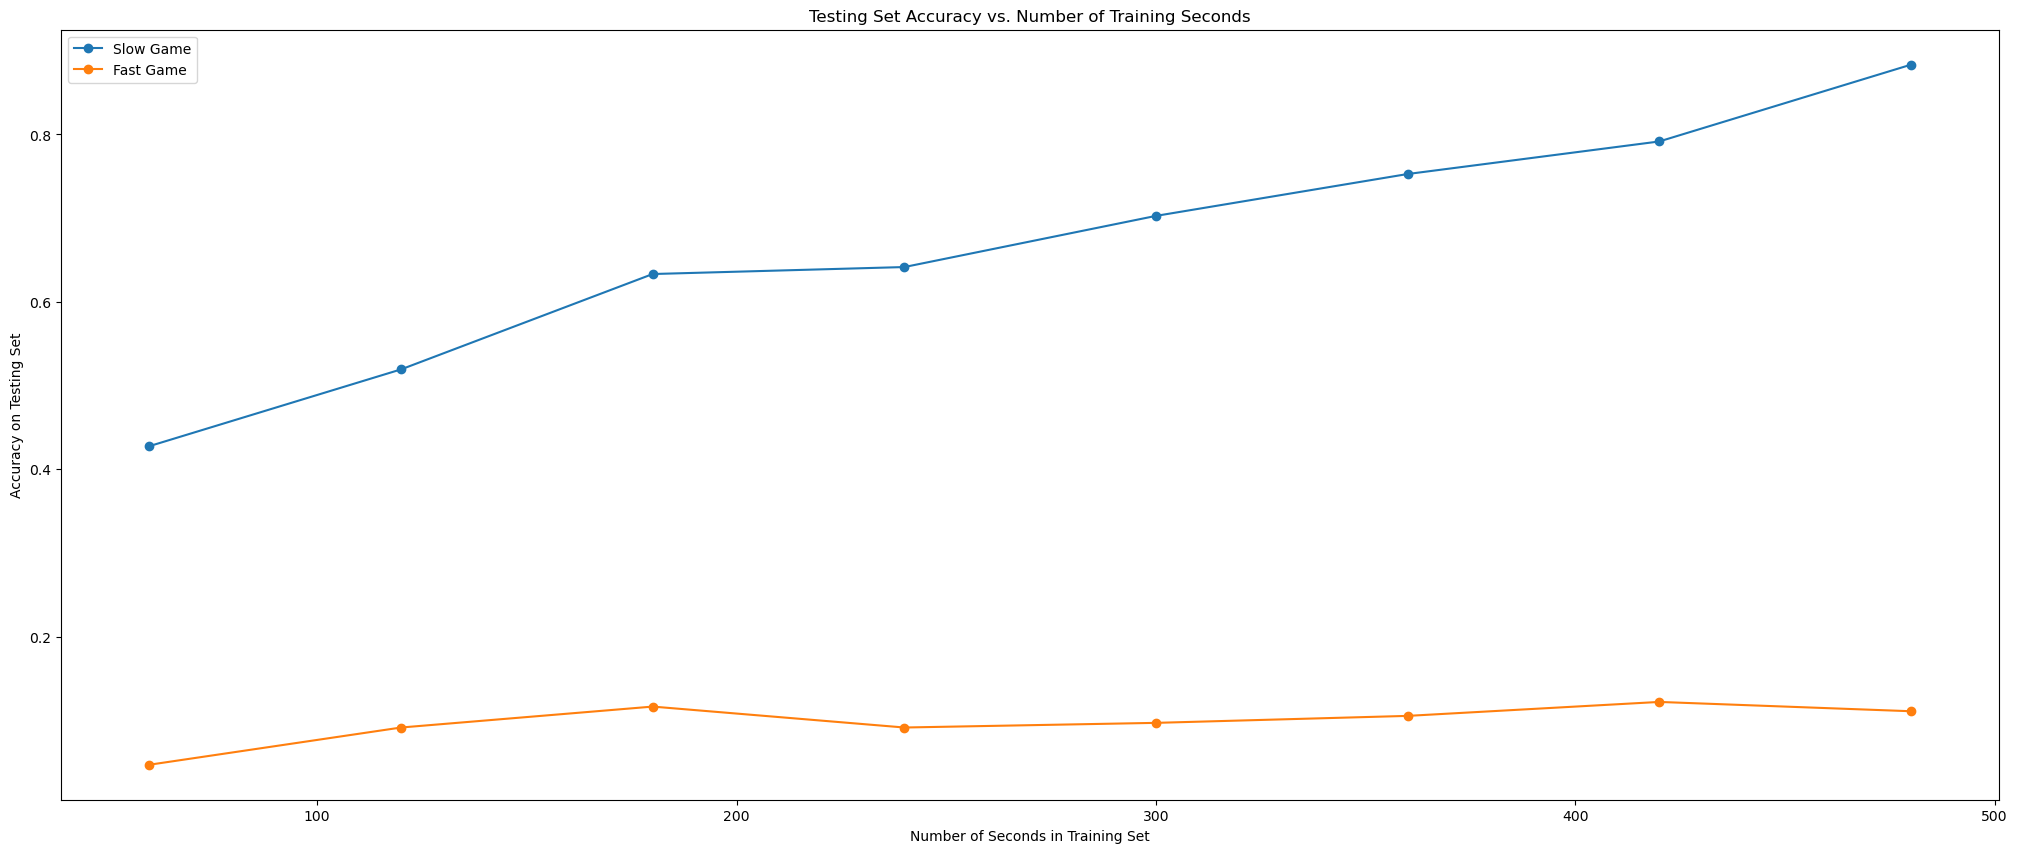


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.427778,0.047222
1,120,0.519444,0.091667
2,180,0.633333,0.116667
3,240,0.641667,0.091667
4,300,0.702778,0.097222
5,360,0.752778,0.105556
6,420,0.791667,0.122222
7,480,0.883333,0.111111


In [16]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

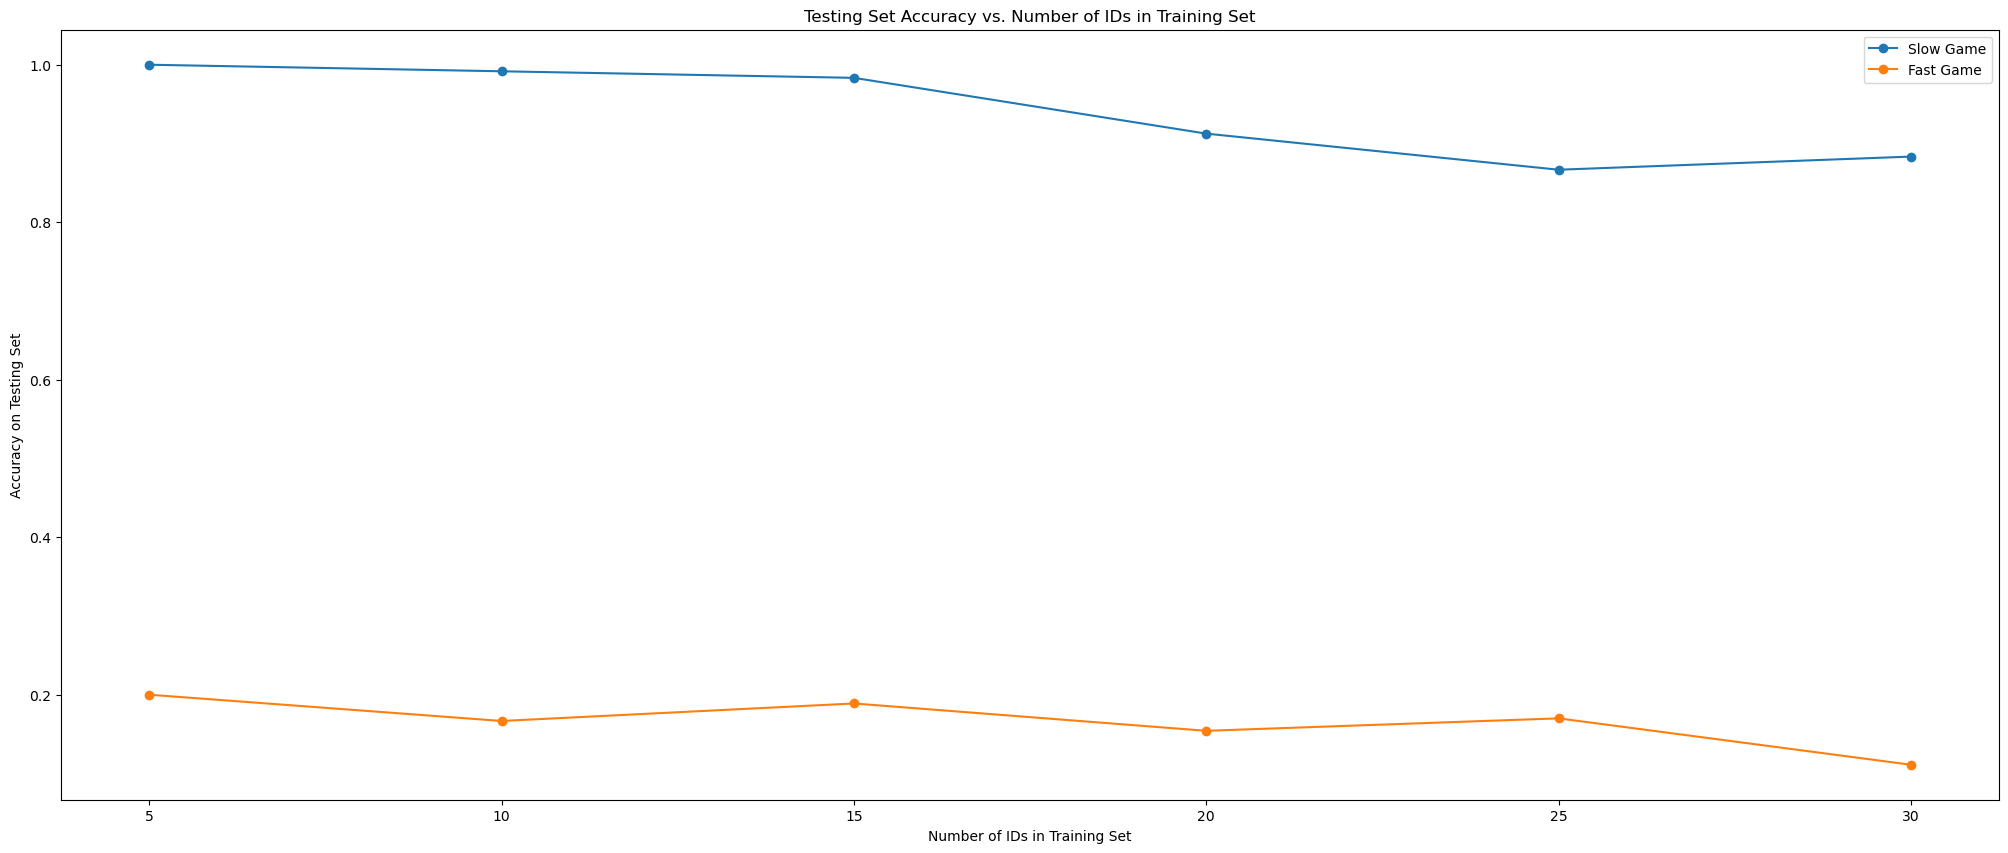


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,1.000000,0.200000
1,10,0.991667,0.166667
2,15,0.983333,0.188889
3,20,0.912500,0.154167
4,25,0.866667,0.170000
5,30,0.883333,0.111111


In [17]:
evaluator.accuracy_over_ids(X_train, y_train, best_model_slow_name,  X_test, y_test,fX_test, fy_test)

### 4.2. Training On Beat Saber

In [18]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast,  best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(fX_train,fy_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Fast)').style.background_gradient(cmap= plt.cm.Blues)

 83%|██████████████████████████████████████████████████████████▎           | 5/6 [00:21<00:06,  6.35s/it]/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:43<00:00,  7.24s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
2,QuadraticDiscriminantAnalysis,1.000000,0.013889,0.097222,1.000000,0.011246,0.095014,1.000000,0.009620,0.103835,1.000000,0.013889,0.097222,0.000000,35.543047,32.539409
3,LogisticRegression,0.995833,0.047222,0.922222,0.995840,0.041960,0.915611,0.995931,0.095181,0.947851,0.995833,0.047222,0.922222,0.182890,5.352013,0.414531
4,LGBMClassifier,1.000000,0.113889,0.941667,1.000000,0.097629,0.940027,1.000000,0.096366,0.946976,1.000000,0.113889,0.941667,0.000018,7.711065,0.170451
1,RandomForestClassifier,1.000000,0.127778,0.969444,1.000000,0.116440,0.969859,1.000000,0.109898,0.974054,1.000000,0.127778,0.969444,0.103891,9.005432,0.486686
0,ExtraTreesClassifier,1.000000,0.147222,0.975000,1.000000,0.144237,0.974475,1.000000,0.160451,0.978101,1.000000,0.147222,0.975000,0.000000,4.308886,0.492755
5,VotingClassifier,1.000000,0.102778,0.983333,1.000000,0.079205,0.983002,1.000000,0.068993,0.984554,1.000000,0.102778,0.983333,0.051450,3.956922,0.511520


In [19]:
explainer = shap.TreeExplainer(best_model_fast)
shap_values_fast = explainer.shap_values(fX_test)

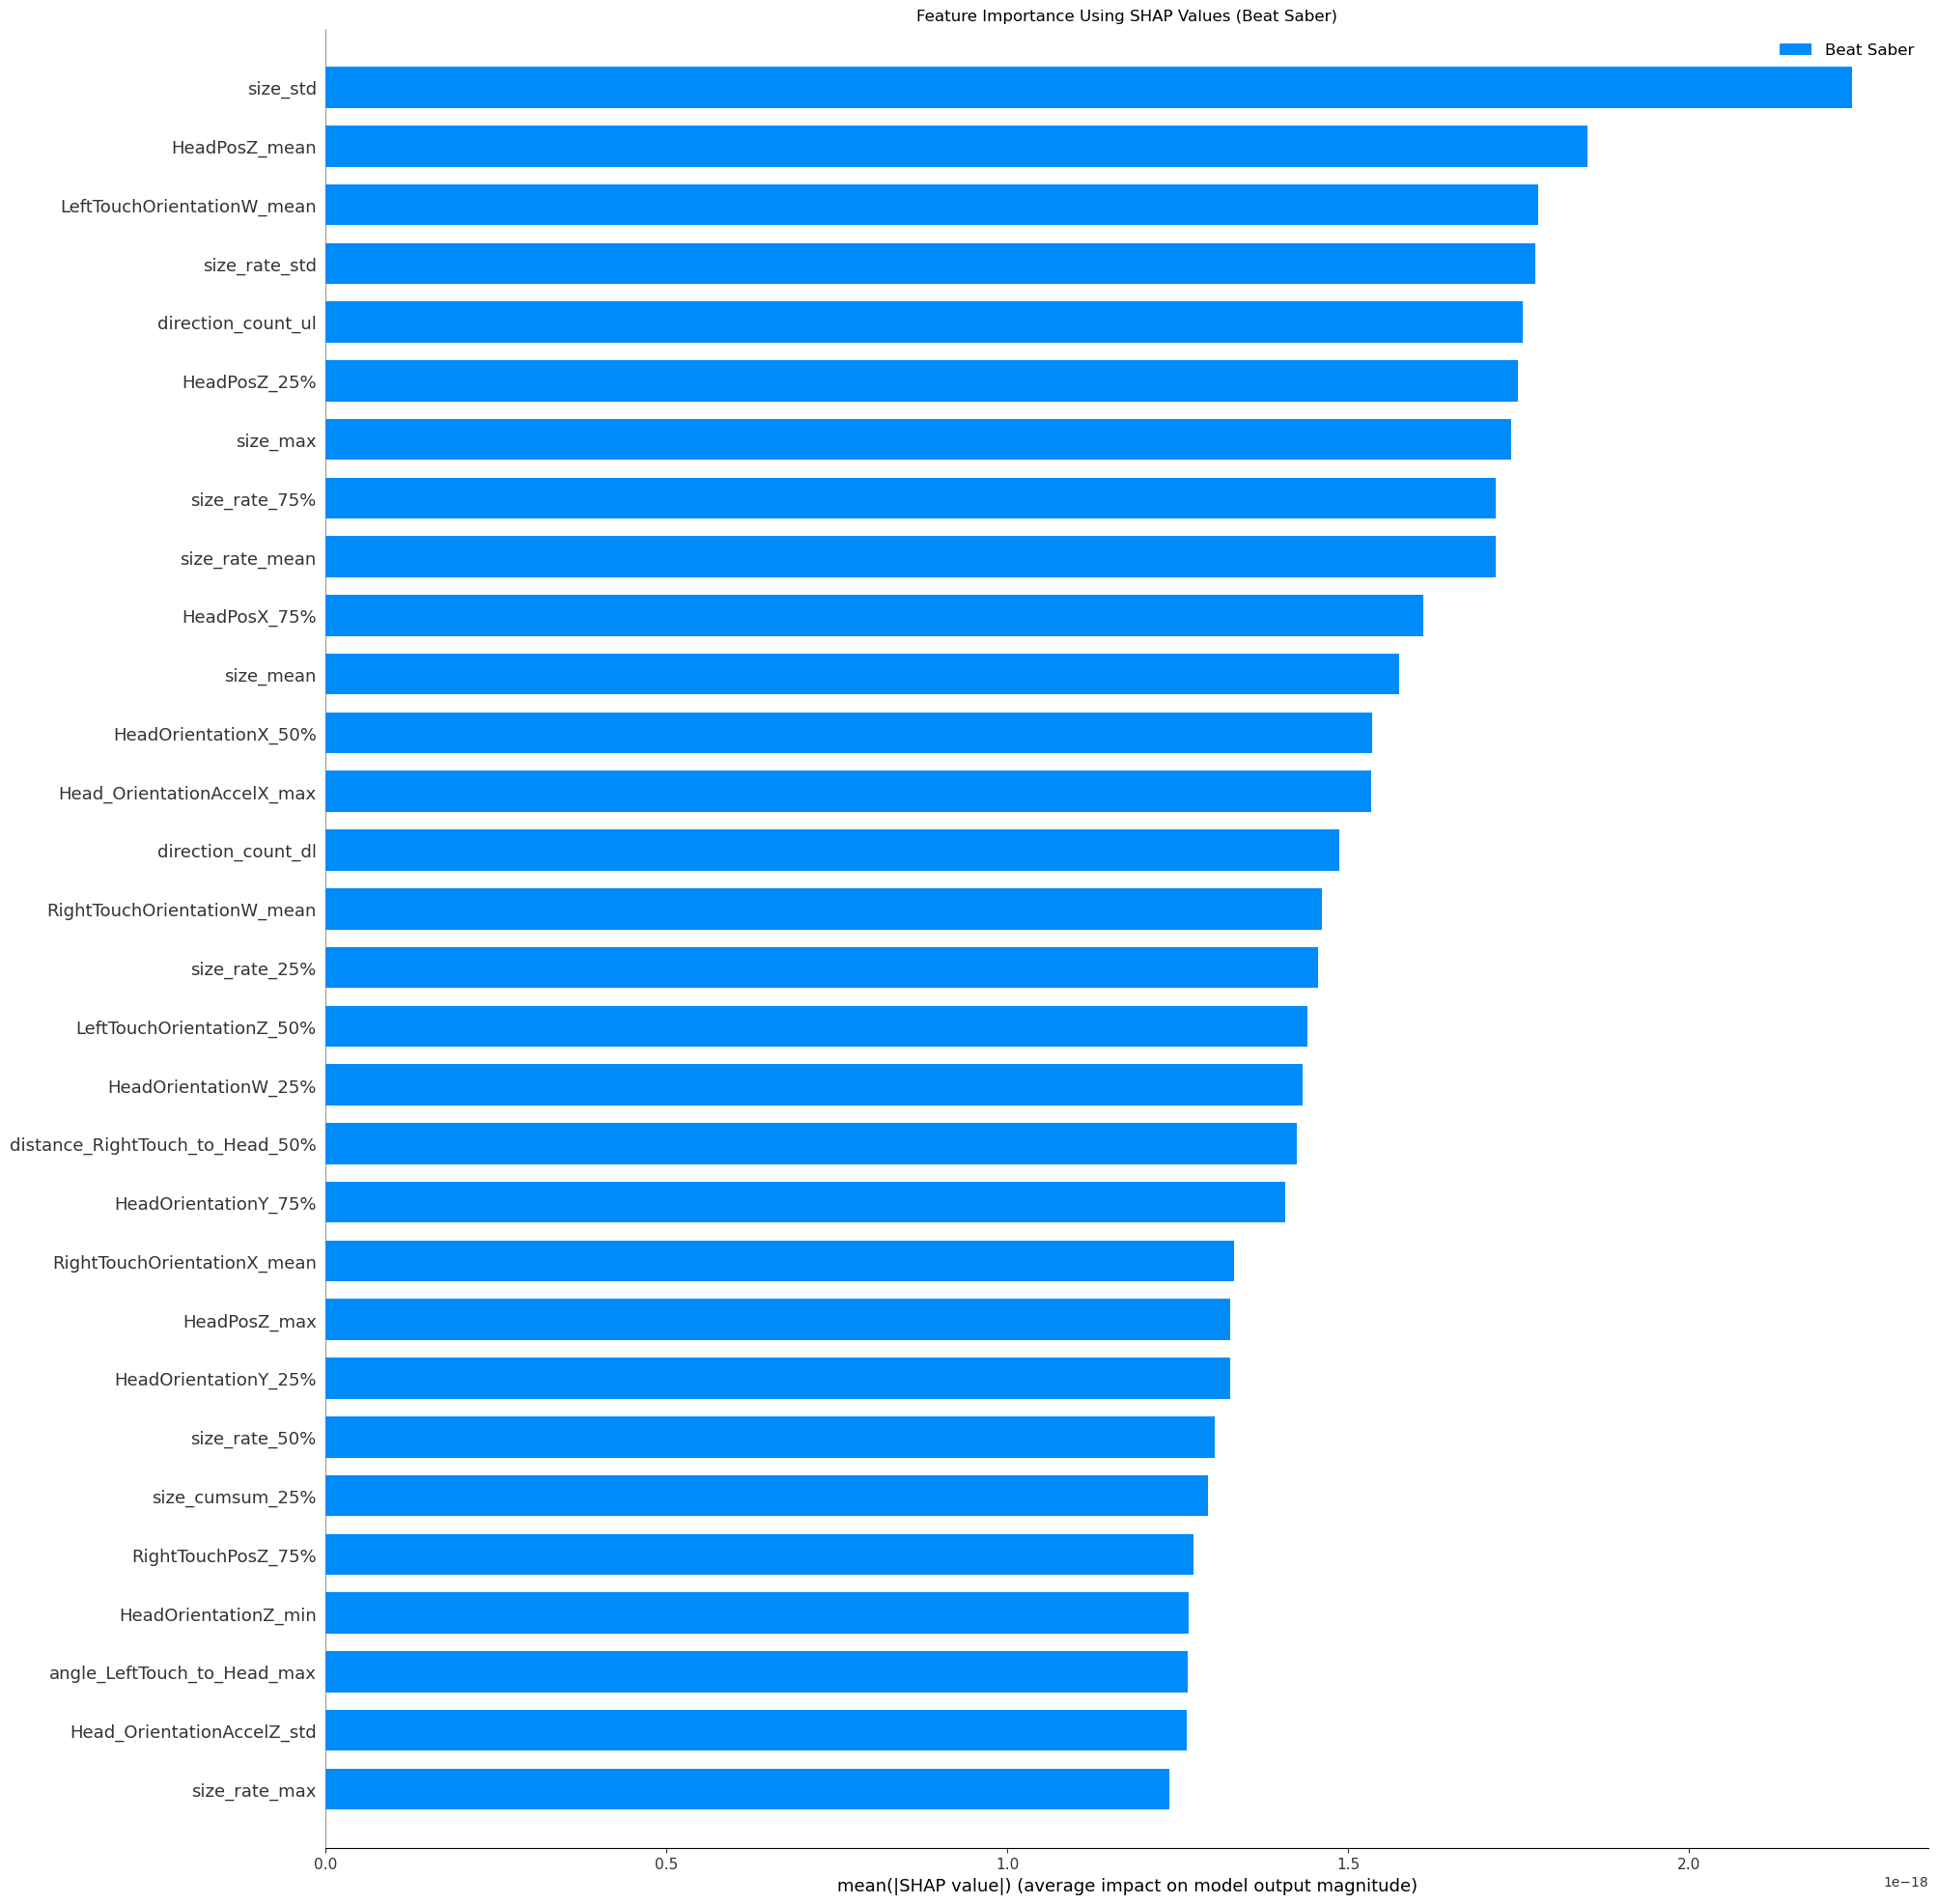

In [20]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast, axis=2)], 
                          fX_test, title="Feature Importance Using SHAP Values (Beat Saber)",
                          class_names=['Beat Saber'])

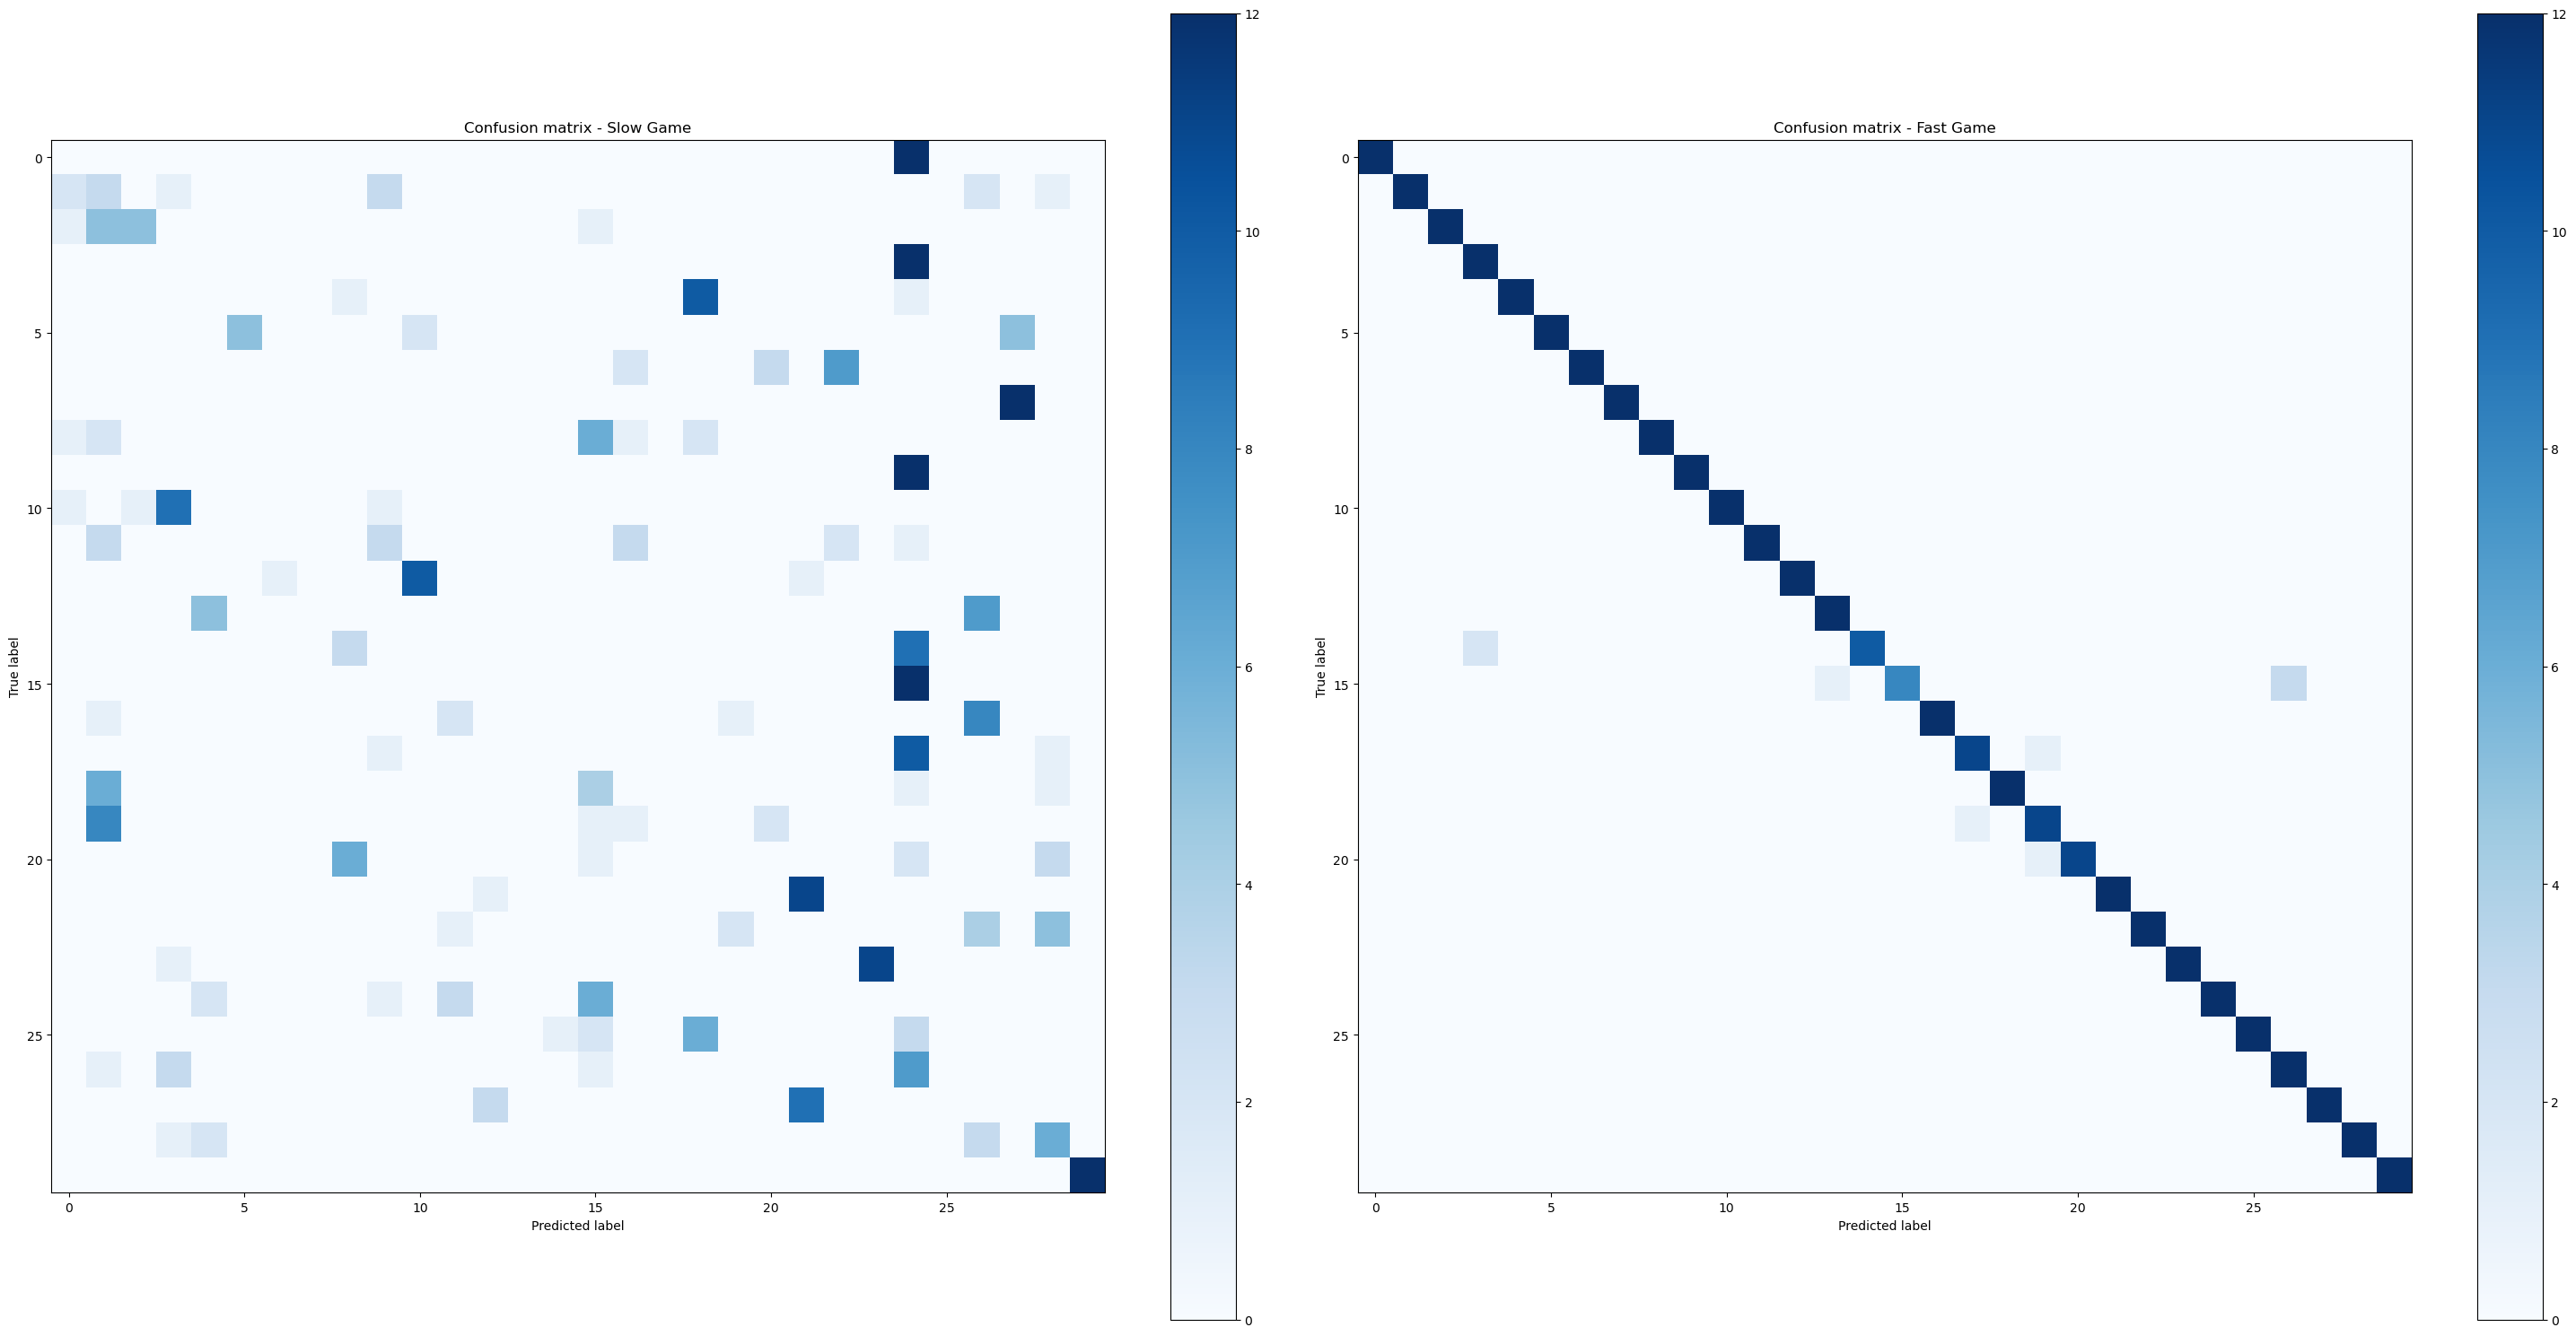

In [21]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

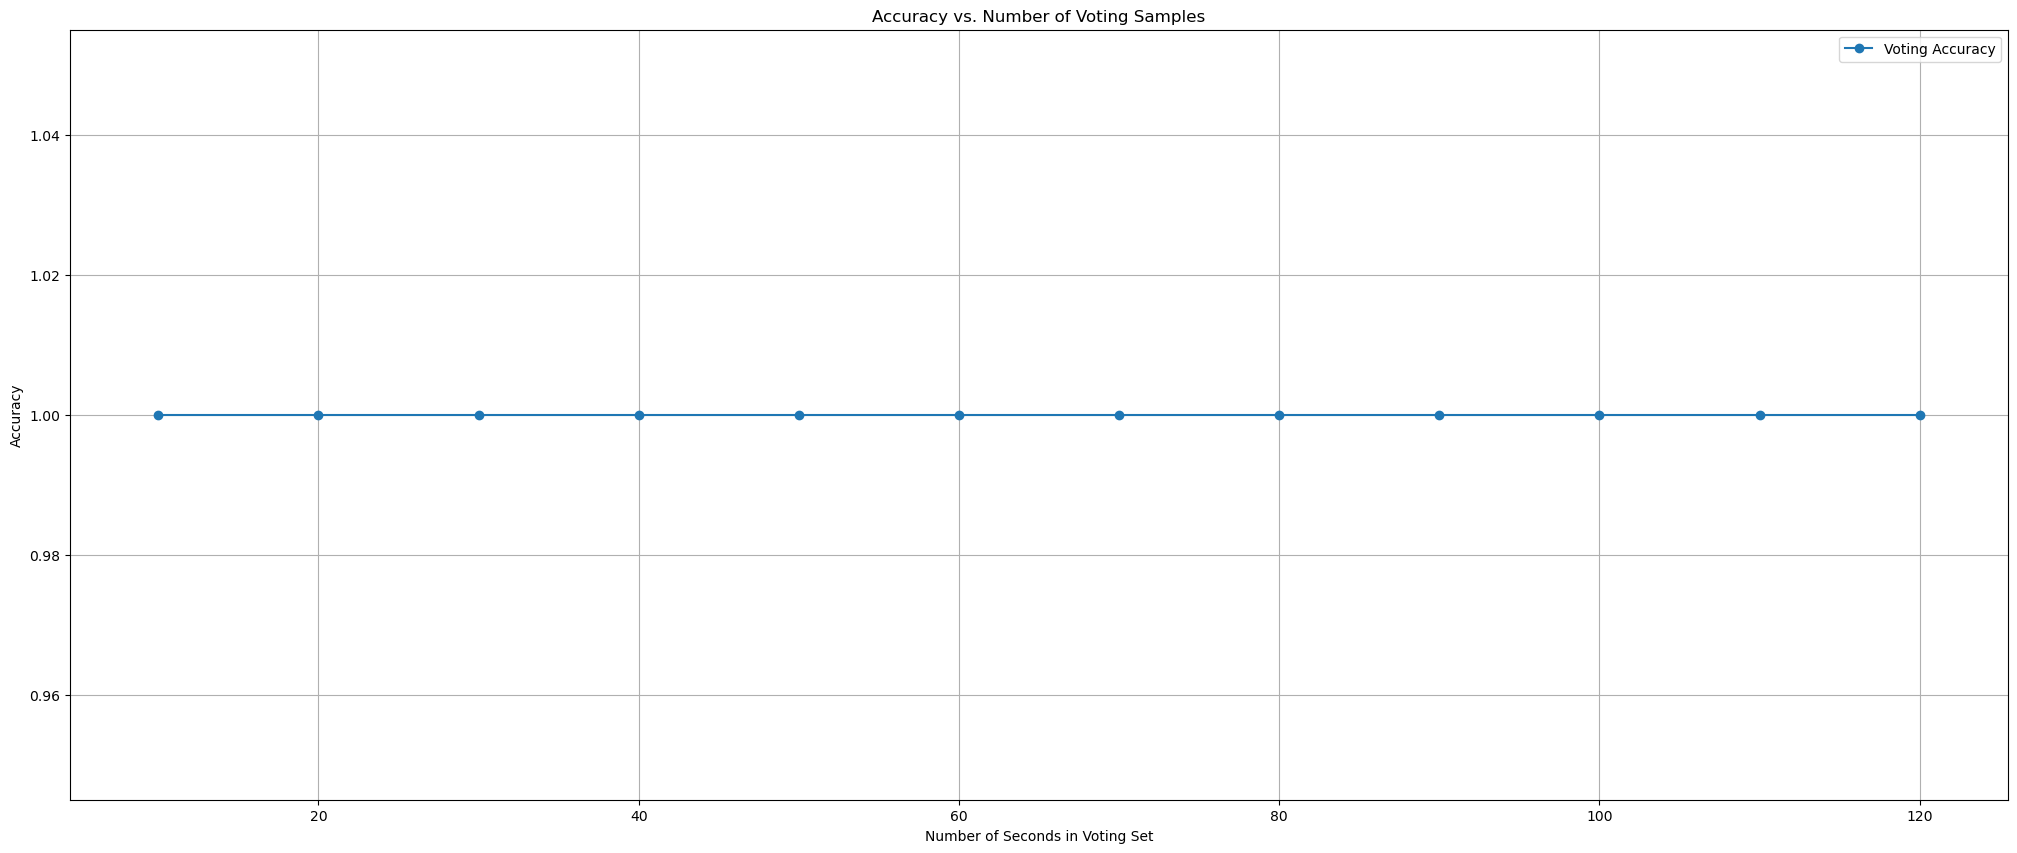


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,1.0
1,20,1.0
2,30,1.0
3,40,1.0
4,50,1.0
5,60,1.0
6,70,1.0
7,80,1.0
8,90,1.0
9,100,1.0


In [22]:
evaluator.plot_accuracy_by_vote(best_model_fast, fX_test, fy_test, increment=1)

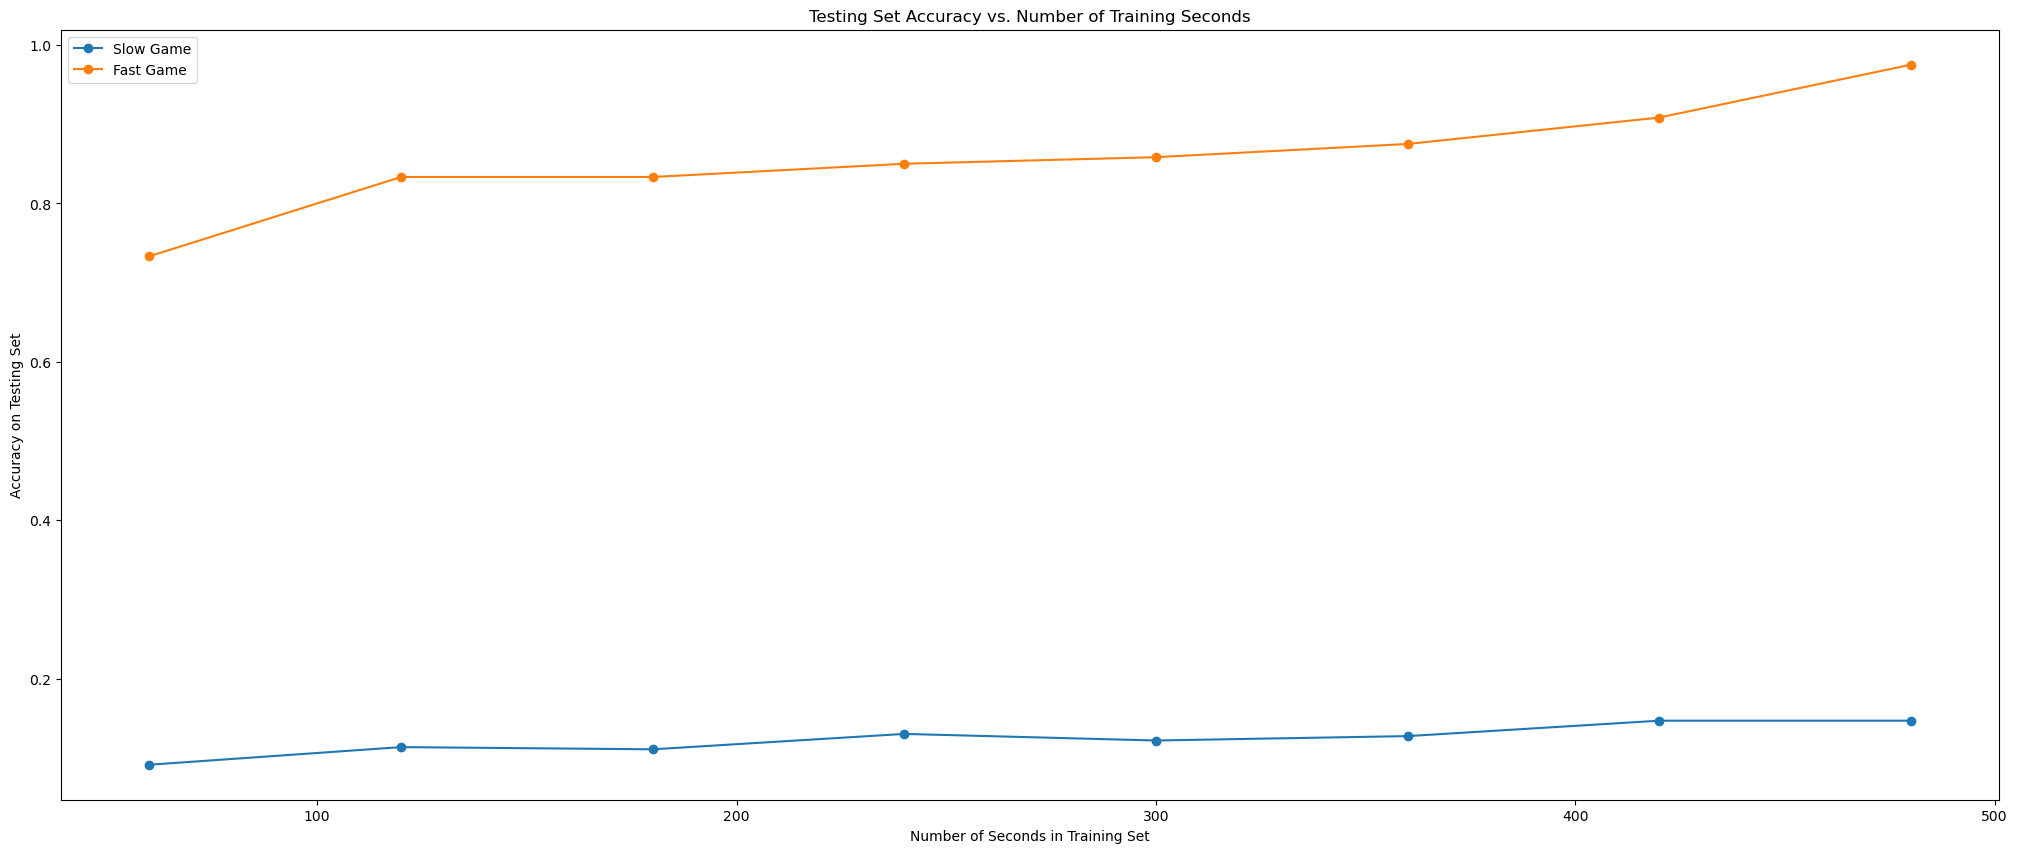


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.091667,0.733333
1,120,0.113889,0.833333
2,180,0.111111,0.833333
3,240,0.130556,0.850000
4,300,0.122222,0.858333
5,360,0.127778,0.875000
6,420,0.147222,0.908333
7,480,0.147222,0.975000


In [23]:
evaluator.accuracy_over_time(fX, fy, best_model_fast_name, range(1,9), X_test, y_test, fX_test, fy_test)

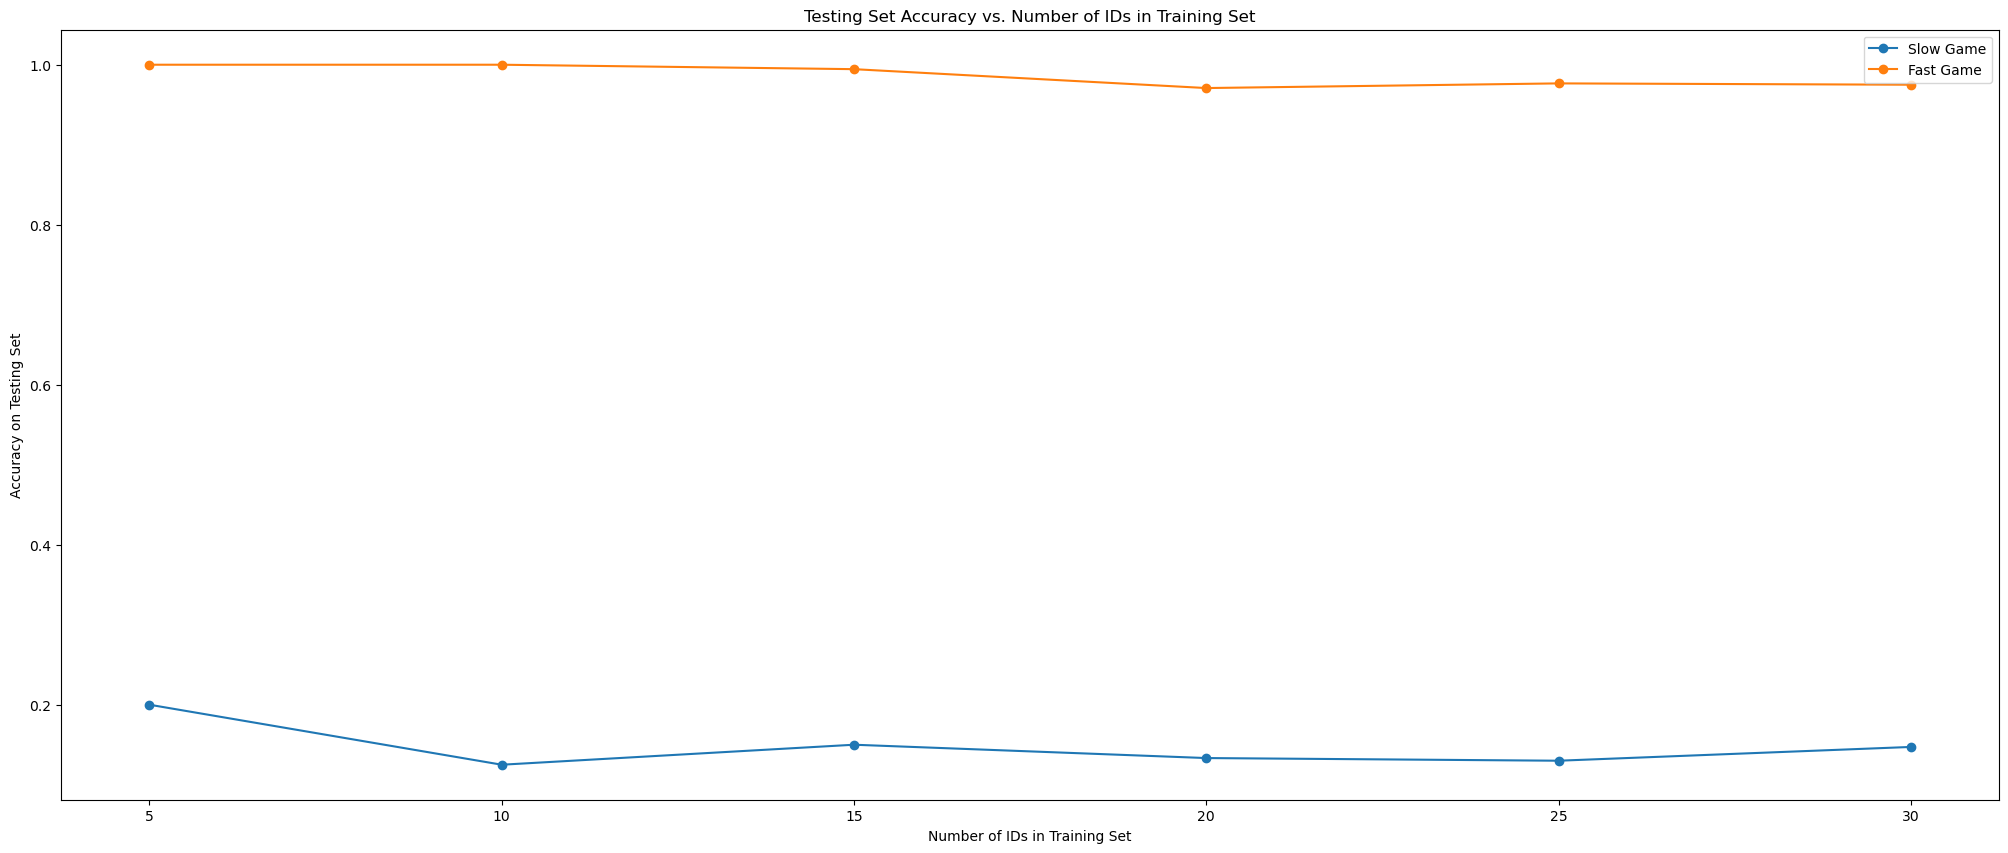


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.200000,1.000000
1,10,0.125000,1.000000
2,15,0.150000,0.994444
3,20,0.133333,0.970833
4,25,0.130000,0.976667
5,30,0.147222,0.975000


In [24]:
evaluator.accuracy_over_ids(fX_train, fy_train, best_model_fast_name, X_test, y_test,fX_test, fy_test)

### 4.3. Training On Forklift Simulator

In [25]:
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(mov_slow, mov_fast, id_range=range(30,60), train_minutes=8, test_minutes=2)

Size of the training set:  (1440, 462)
Size of the slow testing set:  (360, 462)
Size of the fast training set:  (1440, 462)
Size of the fast testing set:  (360, 462)


In [26]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

 83%|██████████████████████████████████████████████████████████▎           | 5/6 [00:20<00:06,  6.26s/it]/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:36<00:00,  6.14s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
2,QuadraticDiscriminantAnalysis,1.000000,0.144444,0.036111,1.000000,0.143723,0.034797,1.000000,0.170525,0.046995,1.000000,0.144444,0.036111,0.000000,30.837348,34.742077
4,LGBMClassifier,1.000000,0.947222,0.033333,1.000000,0.947464,0.011821,1.000000,0.954750,0.007207,1.000000,0.947222,0.033333,0.000018,0.235997,11.470965
3,LogisticRegression,0.977083,0.950000,0.055556,0.977070,0.950272,0.017631,0.977970,0.960110,0.011502,0.977083,0.950000,0.055556,0.410015,0.436743,10.470060
1,RandomForestClassifier,1.000000,0.975000,0.038889,1.000000,0.973426,0.028413,1.000000,0.979600,0.038758,1.000000,0.975000,0.038889,0.069095,0.341248,16.019518
5,VotingClassifier,1.000000,0.980556,0.066667,1.000000,0.980493,0.037234,1.000000,0.982418,0.032662,1.000000,0.980556,0.066667,0.076091,0.468532,5.317427
0,ExtraTreesClassifier,1.000000,0.997222,0.058333,1.000000,0.997217,0.030330,1.000000,0.997436,0.033788,1.000000,0.997222,0.058333,0.000000,0.336477,5.914243


In [27]:
explainer = shap.TreeExplainer(best_model_slow)
shap_values_slow = explainer.shap_values(X_test)

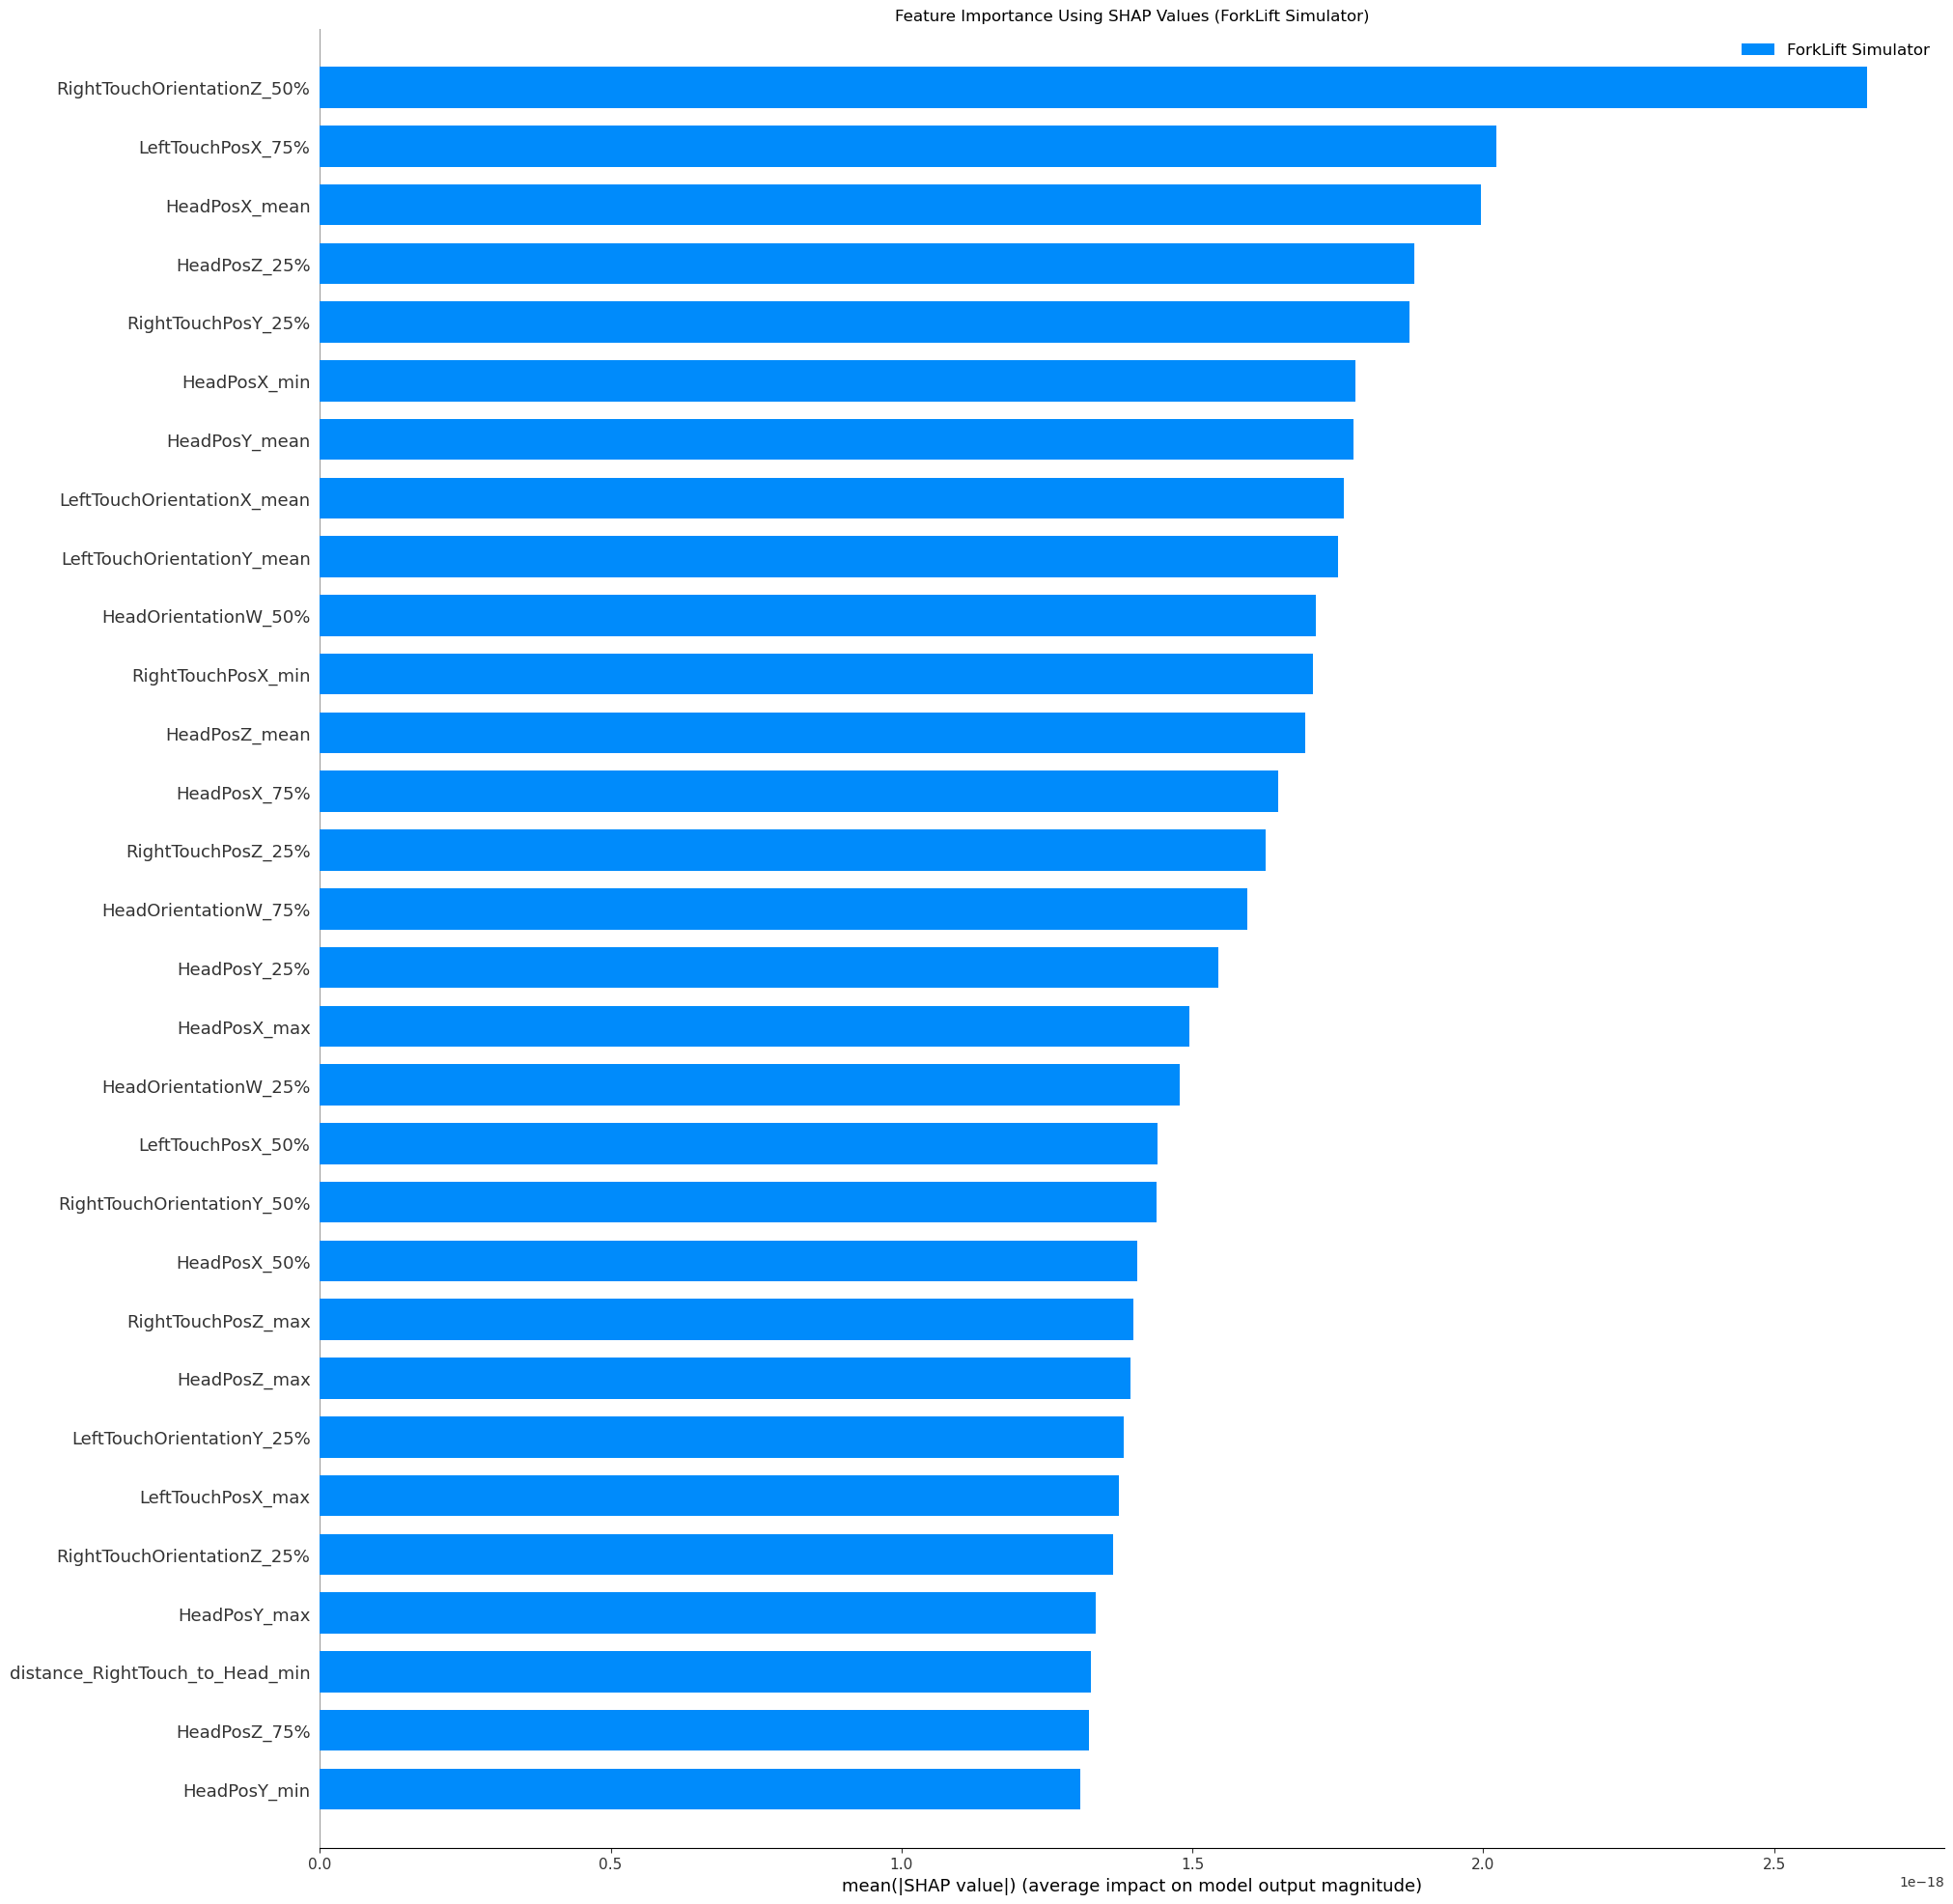

In [28]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow, axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (ForkLift Simulator)",
                          class_names=['ForkLift Simulator'])

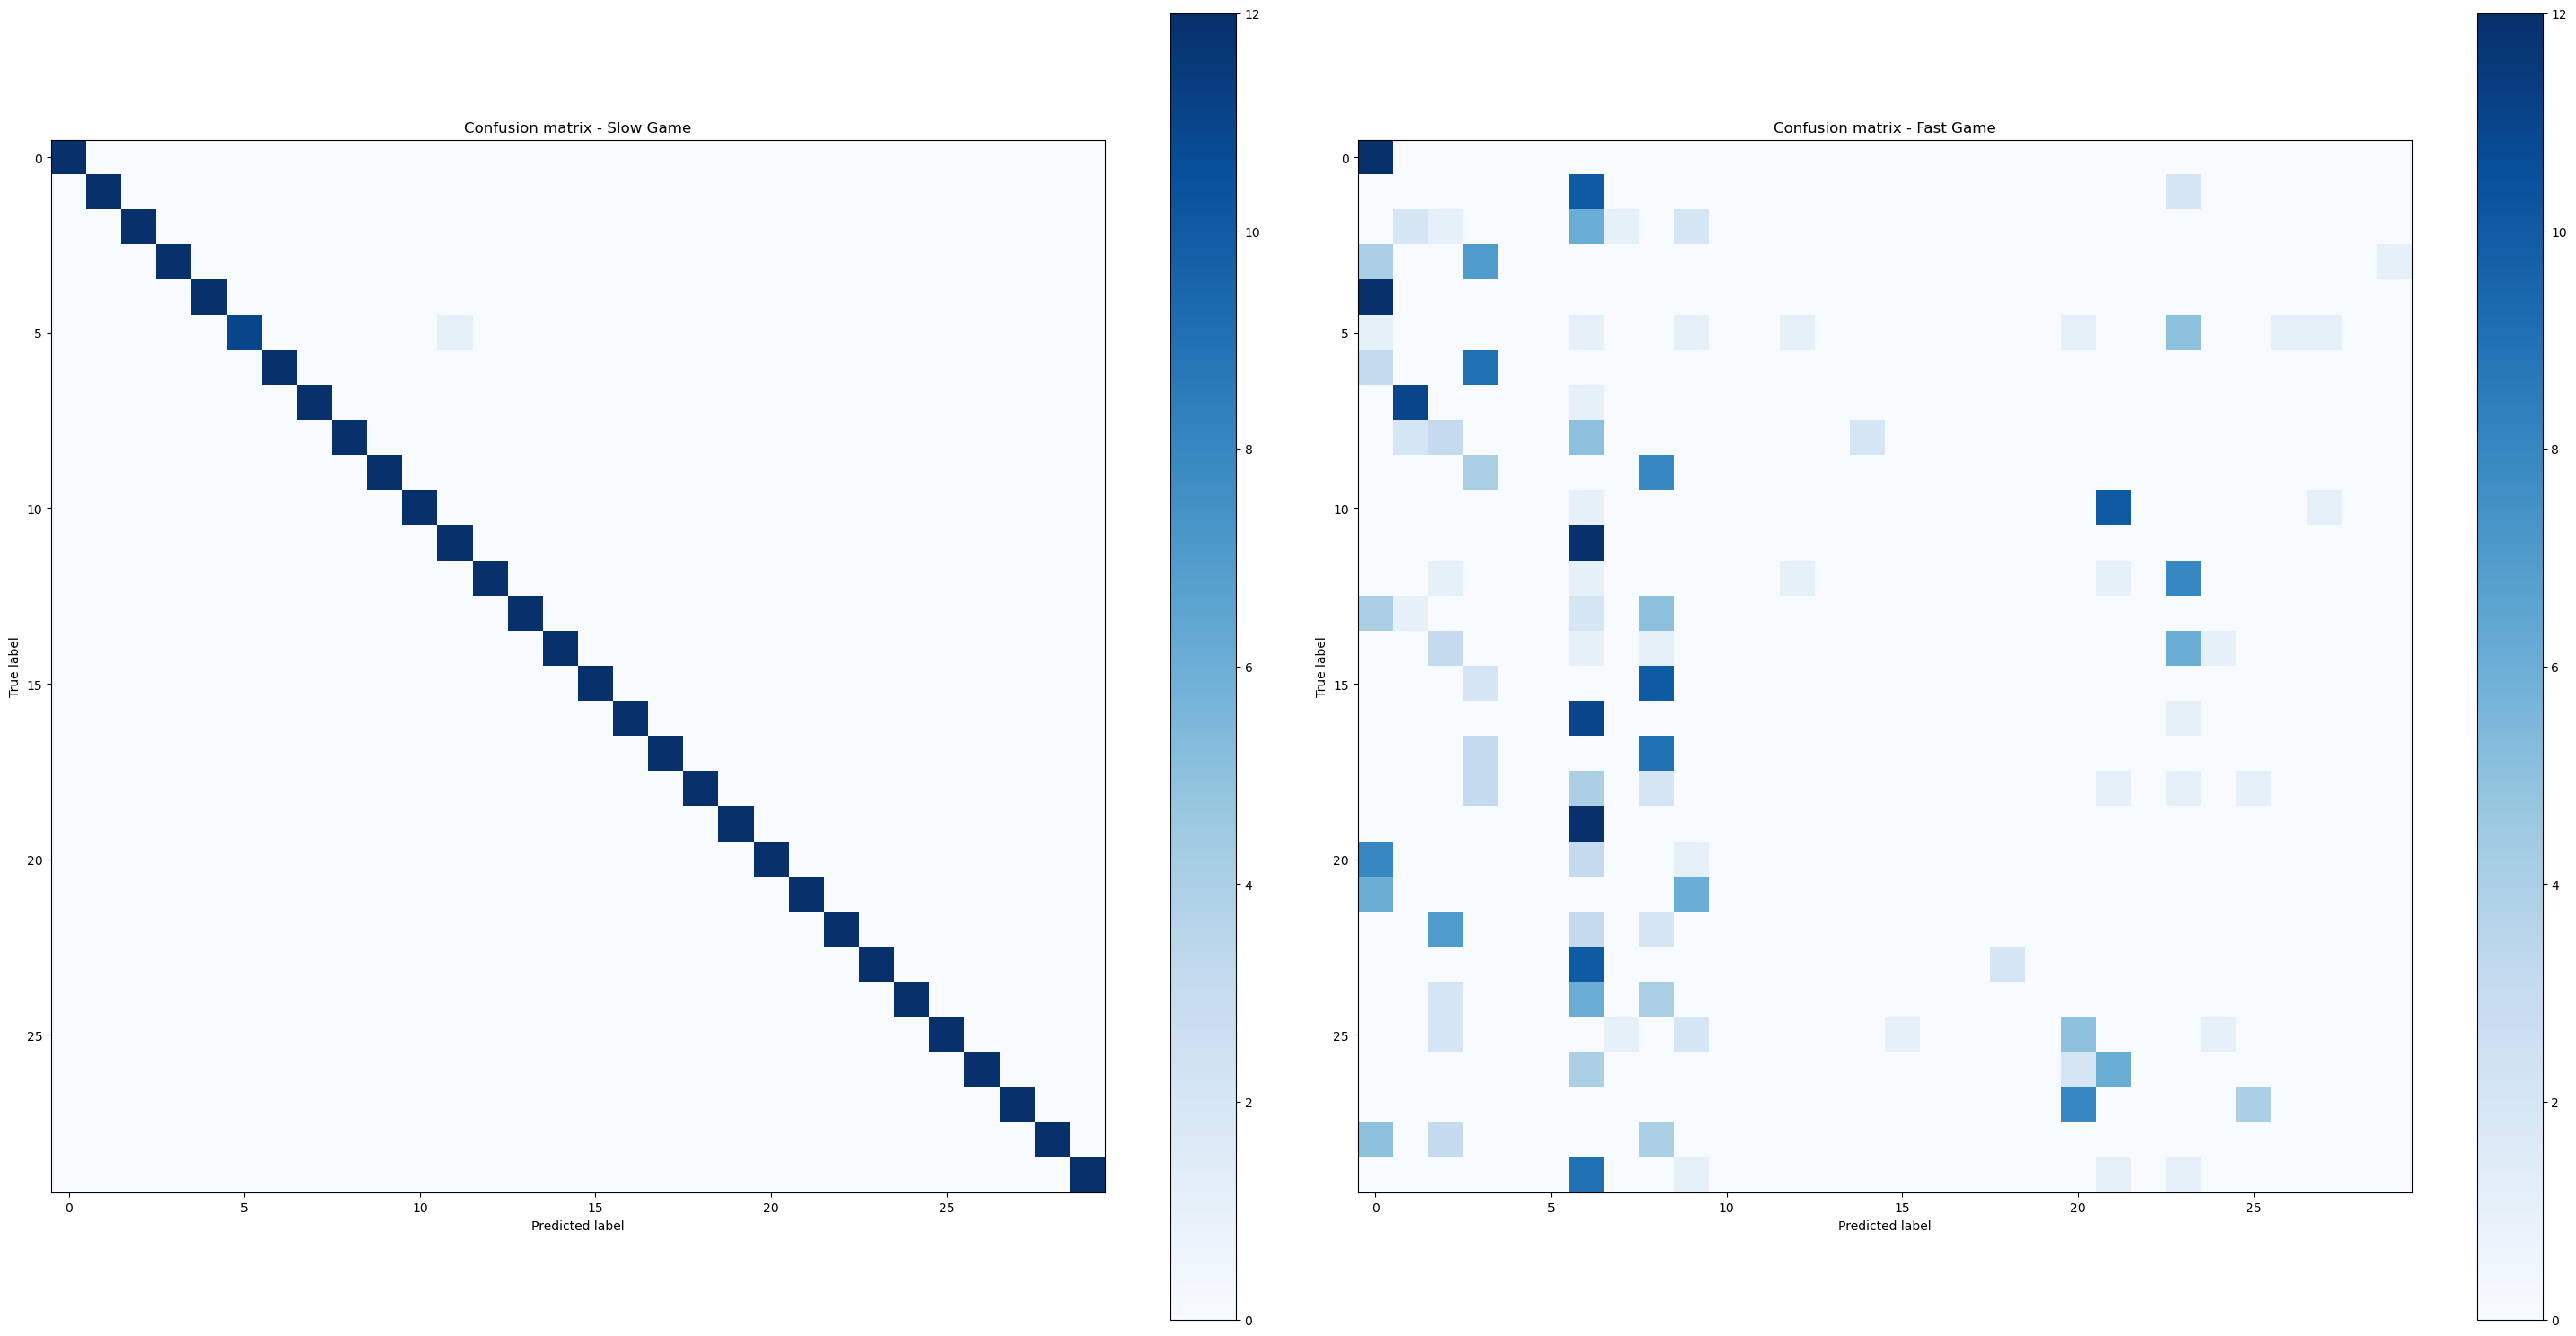

In [29]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

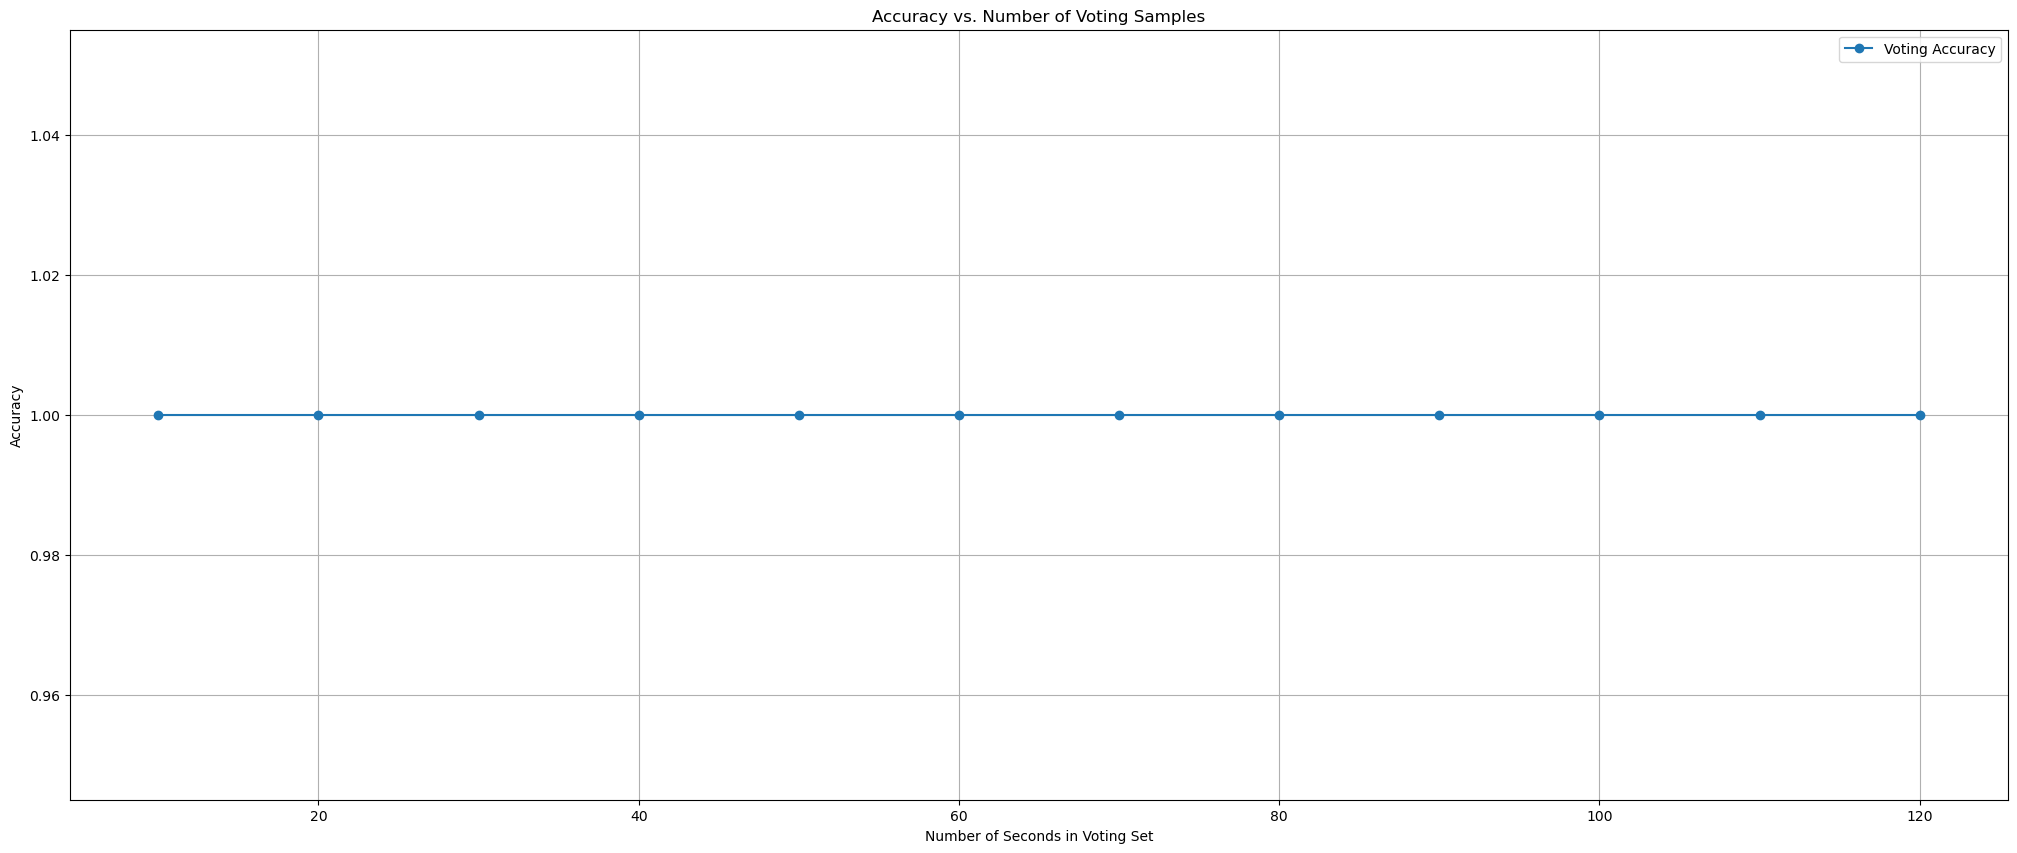


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,1.0
1,20,1.0
2,30,1.0
3,40,1.0
4,50,1.0
5,60,1.0
6,70,1.0
7,80,1.0
8,90,1.0
9,100,1.0


In [30]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

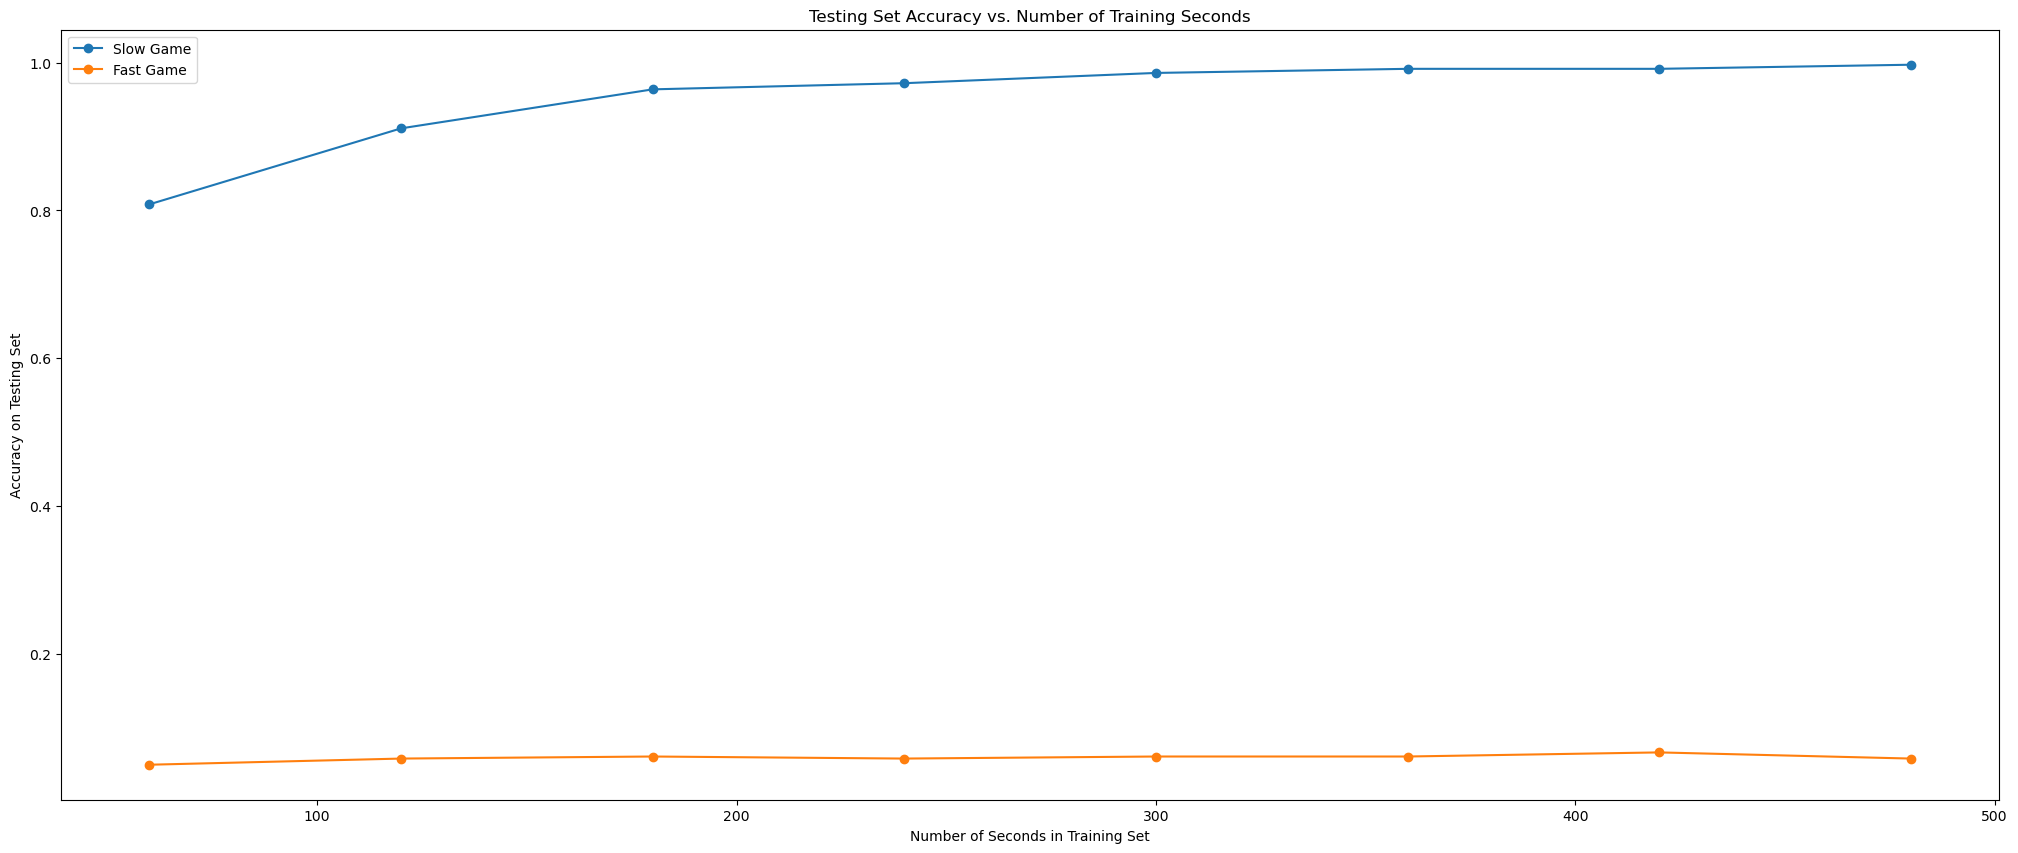


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.808333,0.050000
1,120,0.911111,0.058333
2,180,0.963889,0.061111
3,240,0.972222,0.058333
4,300,0.986111,0.061111
5,360,0.991667,0.061111
6,420,0.991667,0.066667
7,480,0.997222,0.058333


In [31]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

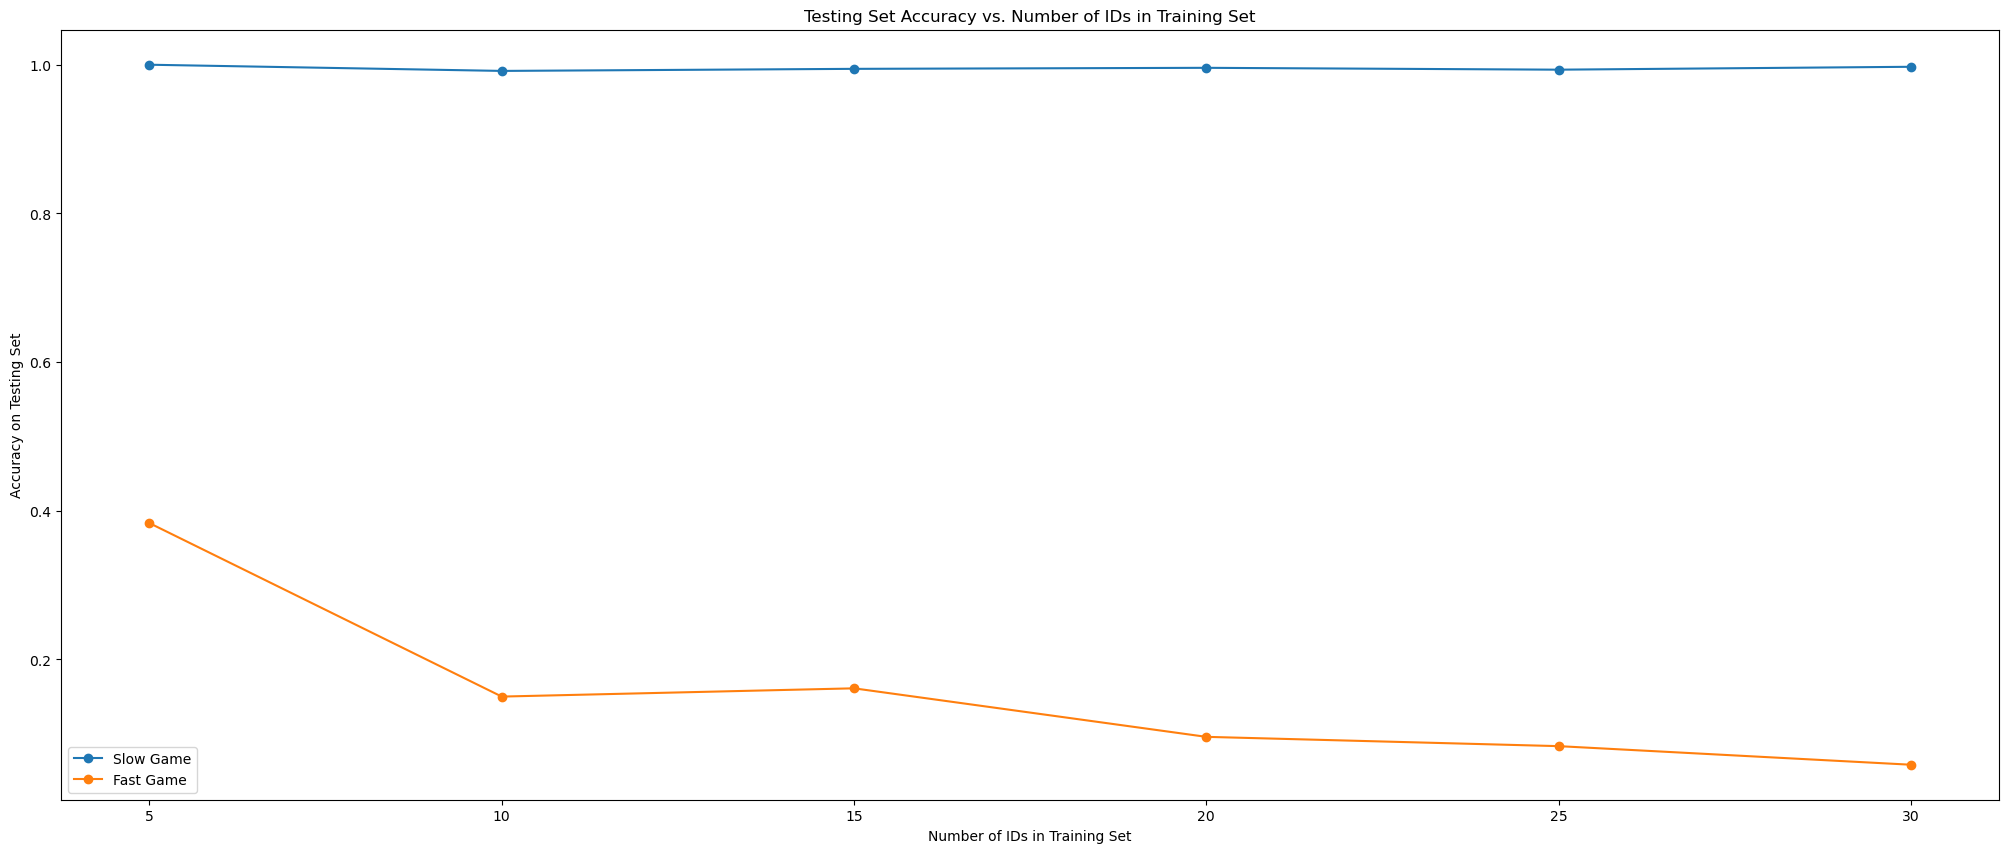


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,1.000000,0.383333
1,10,0.991667,0.150000
2,15,0.994444,0.161111
3,20,0.995833,0.095833
4,25,0.993333,0.083333
5,30,0.997222,0.058333


In [32]:
evaluator.accuracy_over_ids(X_train, y_train,best_model_slow_name, X_test, y_test,fX_test, fy_test)

### 4.4. Training On Medal of Honor

In [33]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(fX_train,fy_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Fast)').style.background_gradient(cmap= plt.cm.Blues)

 83%|██████████████████████████████████████████████████████████▎           | 5/6 [00:18<00:05,  5.19s/it]/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:34<00:00,  5.81s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
2,QuadraticDiscriminantAnalysis,1.000000,0.052778,0.083333,1.000000,0.040050,0.082895,1.000000,0.036203,0.092466,1.000000,0.052778,0.083333,0.000000,34.141349,33.040016
1,RandomForestClassifier,1.000000,0.155556,0.633333,1.000000,0.071638,0.605785,1.000000,0.048167,0.623289,1.000000,0.155556,0.633333,0.168105,13.693489,1.761382
4,LGBMClassifier,1.000000,0.130556,0.650000,1.000000,0.072979,0.629018,1.000000,0.069788,0.643456,1.000000,0.130556,0.650000,0.000019,5.611013,1.405404
3,LogisticRegression,0.970139,0.130556,0.655556,0.969909,0.061936,0.640878,0.970921,0.049830,0.669275,0.970139,0.130556,0.655556,0.334410,4.989827,1.227594
0,ExtraTreesClassifier,1.000000,0.136111,0.669444,1.000000,0.057830,0.643387,1.000000,0.066804,0.671841,1.000000,0.136111,0.669444,0.000000,5.033309,1.282093
5,VotingClassifier,1.000000,0.127778,0.686111,1.000000,0.075445,0.663171,1.000000,0.075324,0.690896,1.000000,0.127778,0.686111,0.084129,4.096589,1.264294


In [34]:
explainer = shap.TreeExplainer(best_model_fast)
shap_values_fast = explainer.shap_values(fX_test)

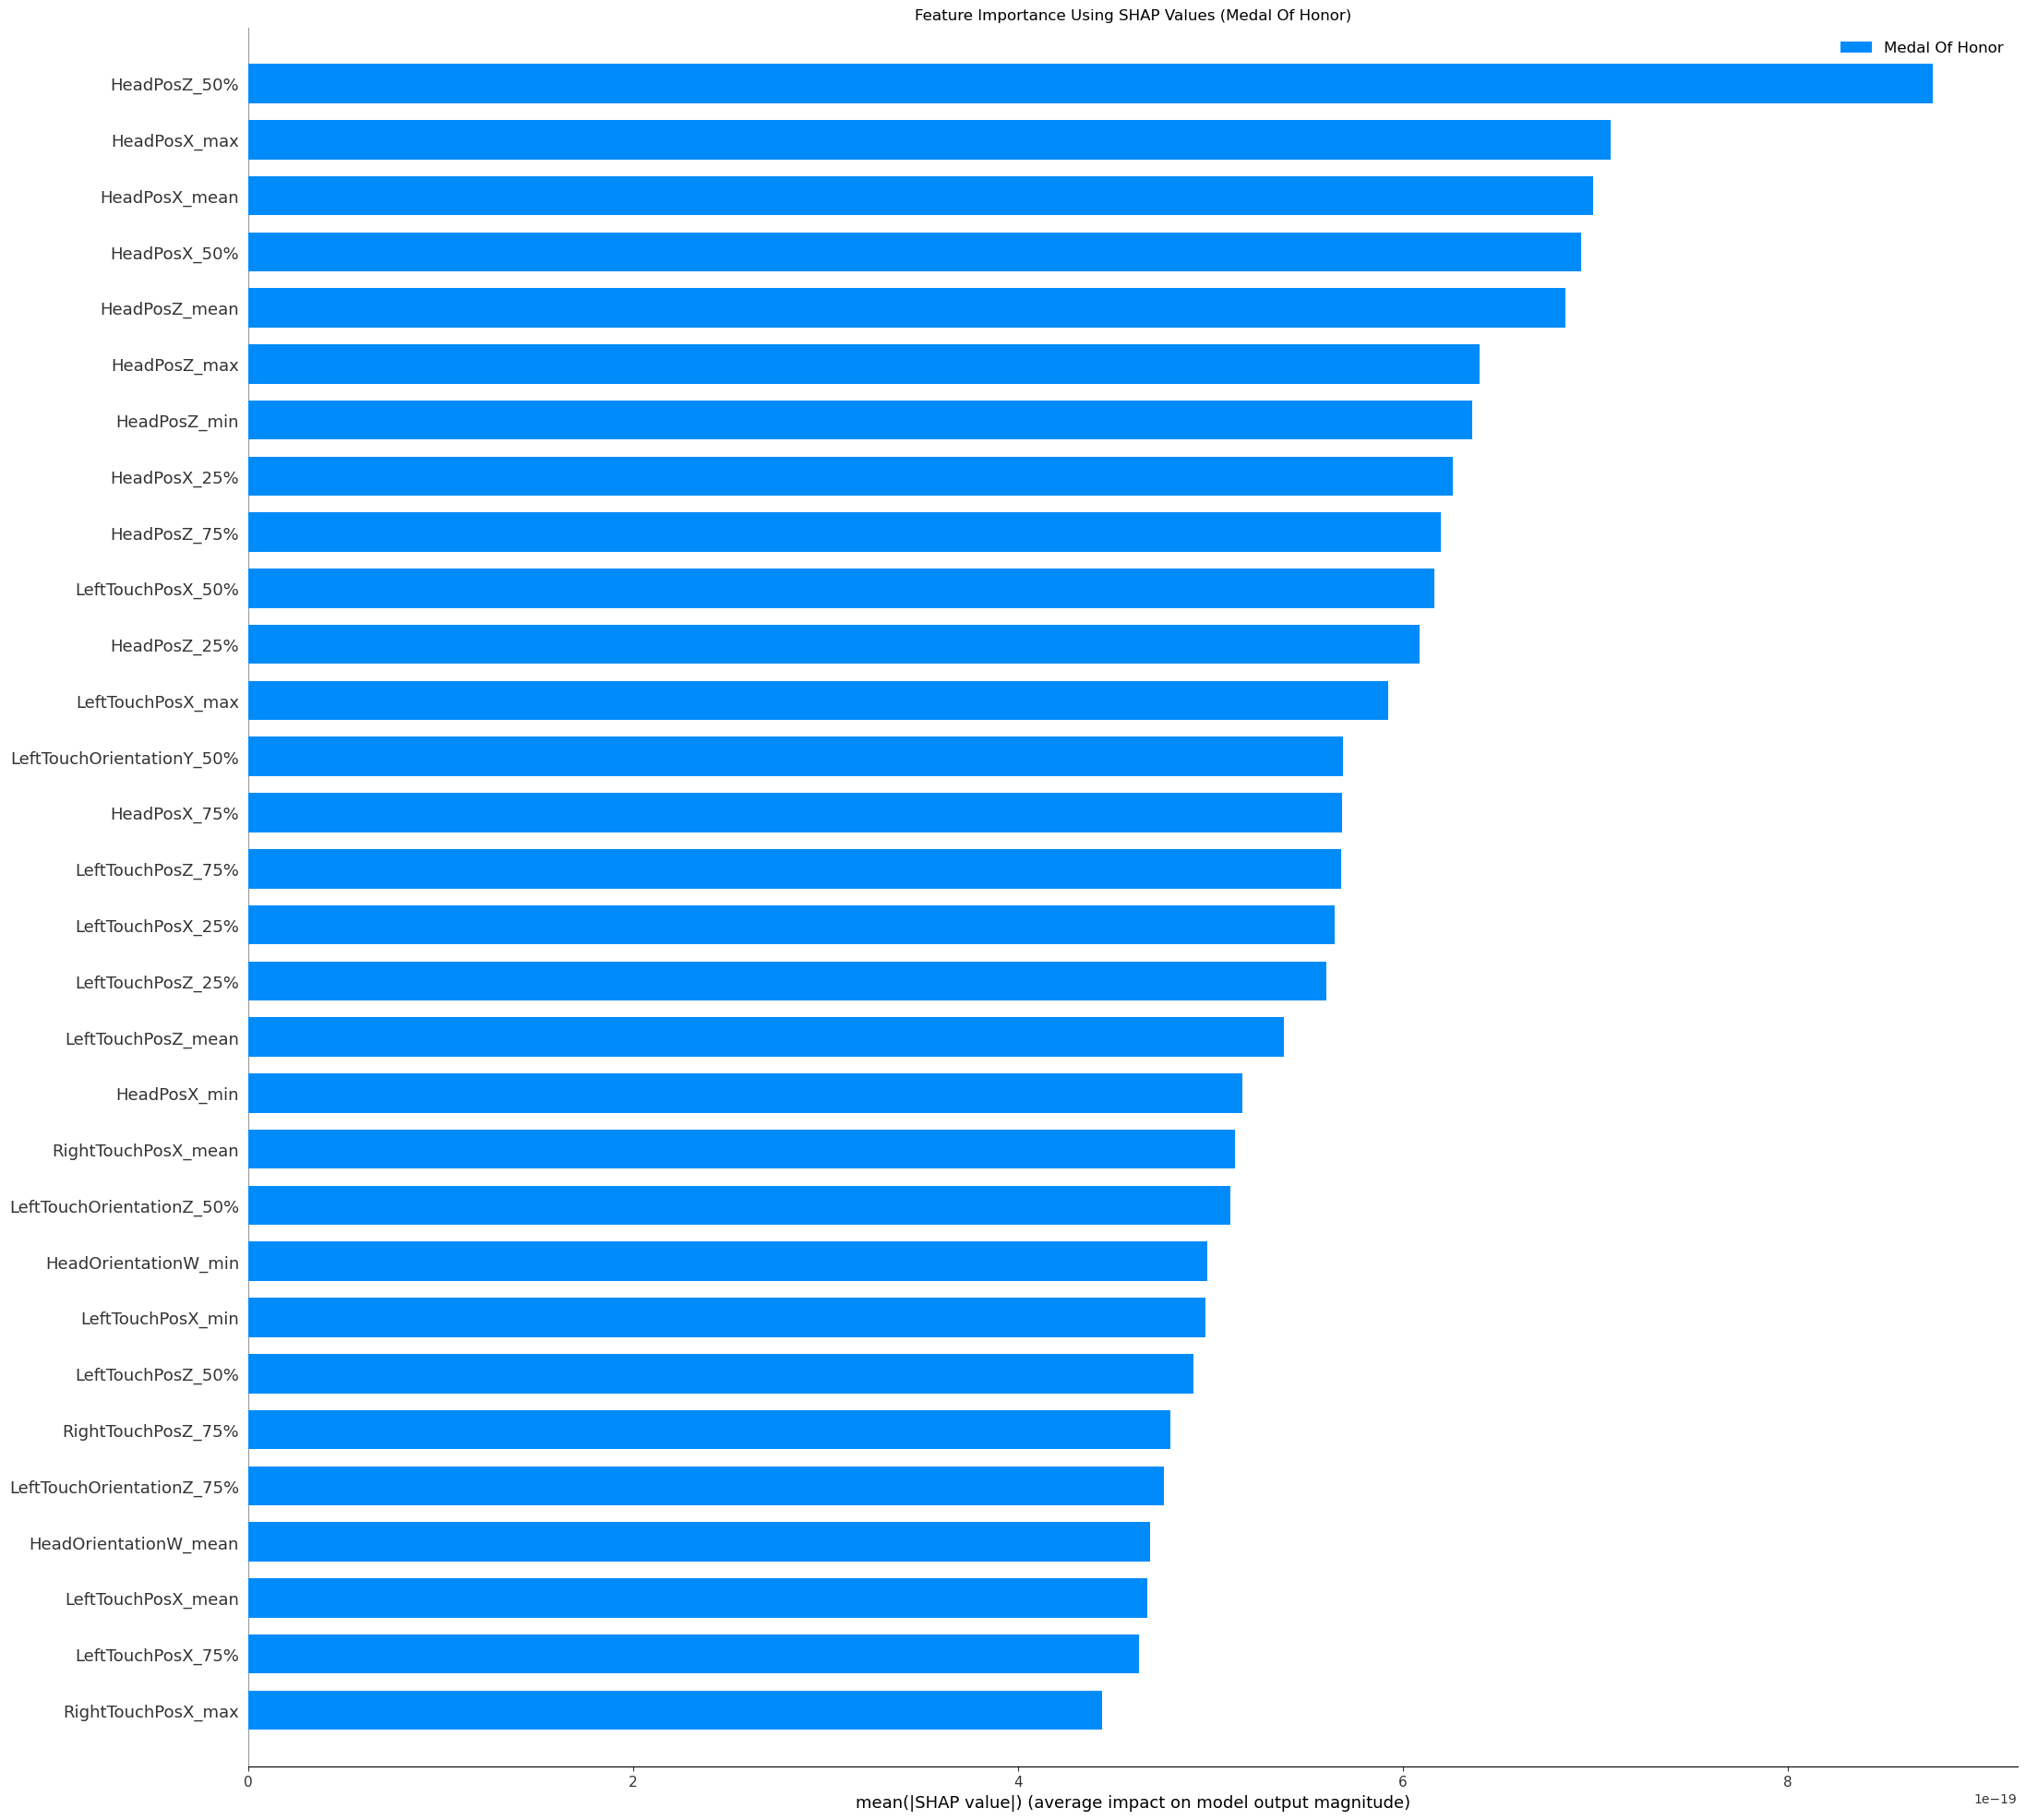

In [35]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast, axis=2)], 
                          fX_test, title="Feature Importance Using SHAP Values (Medal Of Honor)",
                          class_names=['Medal Of Honor'])

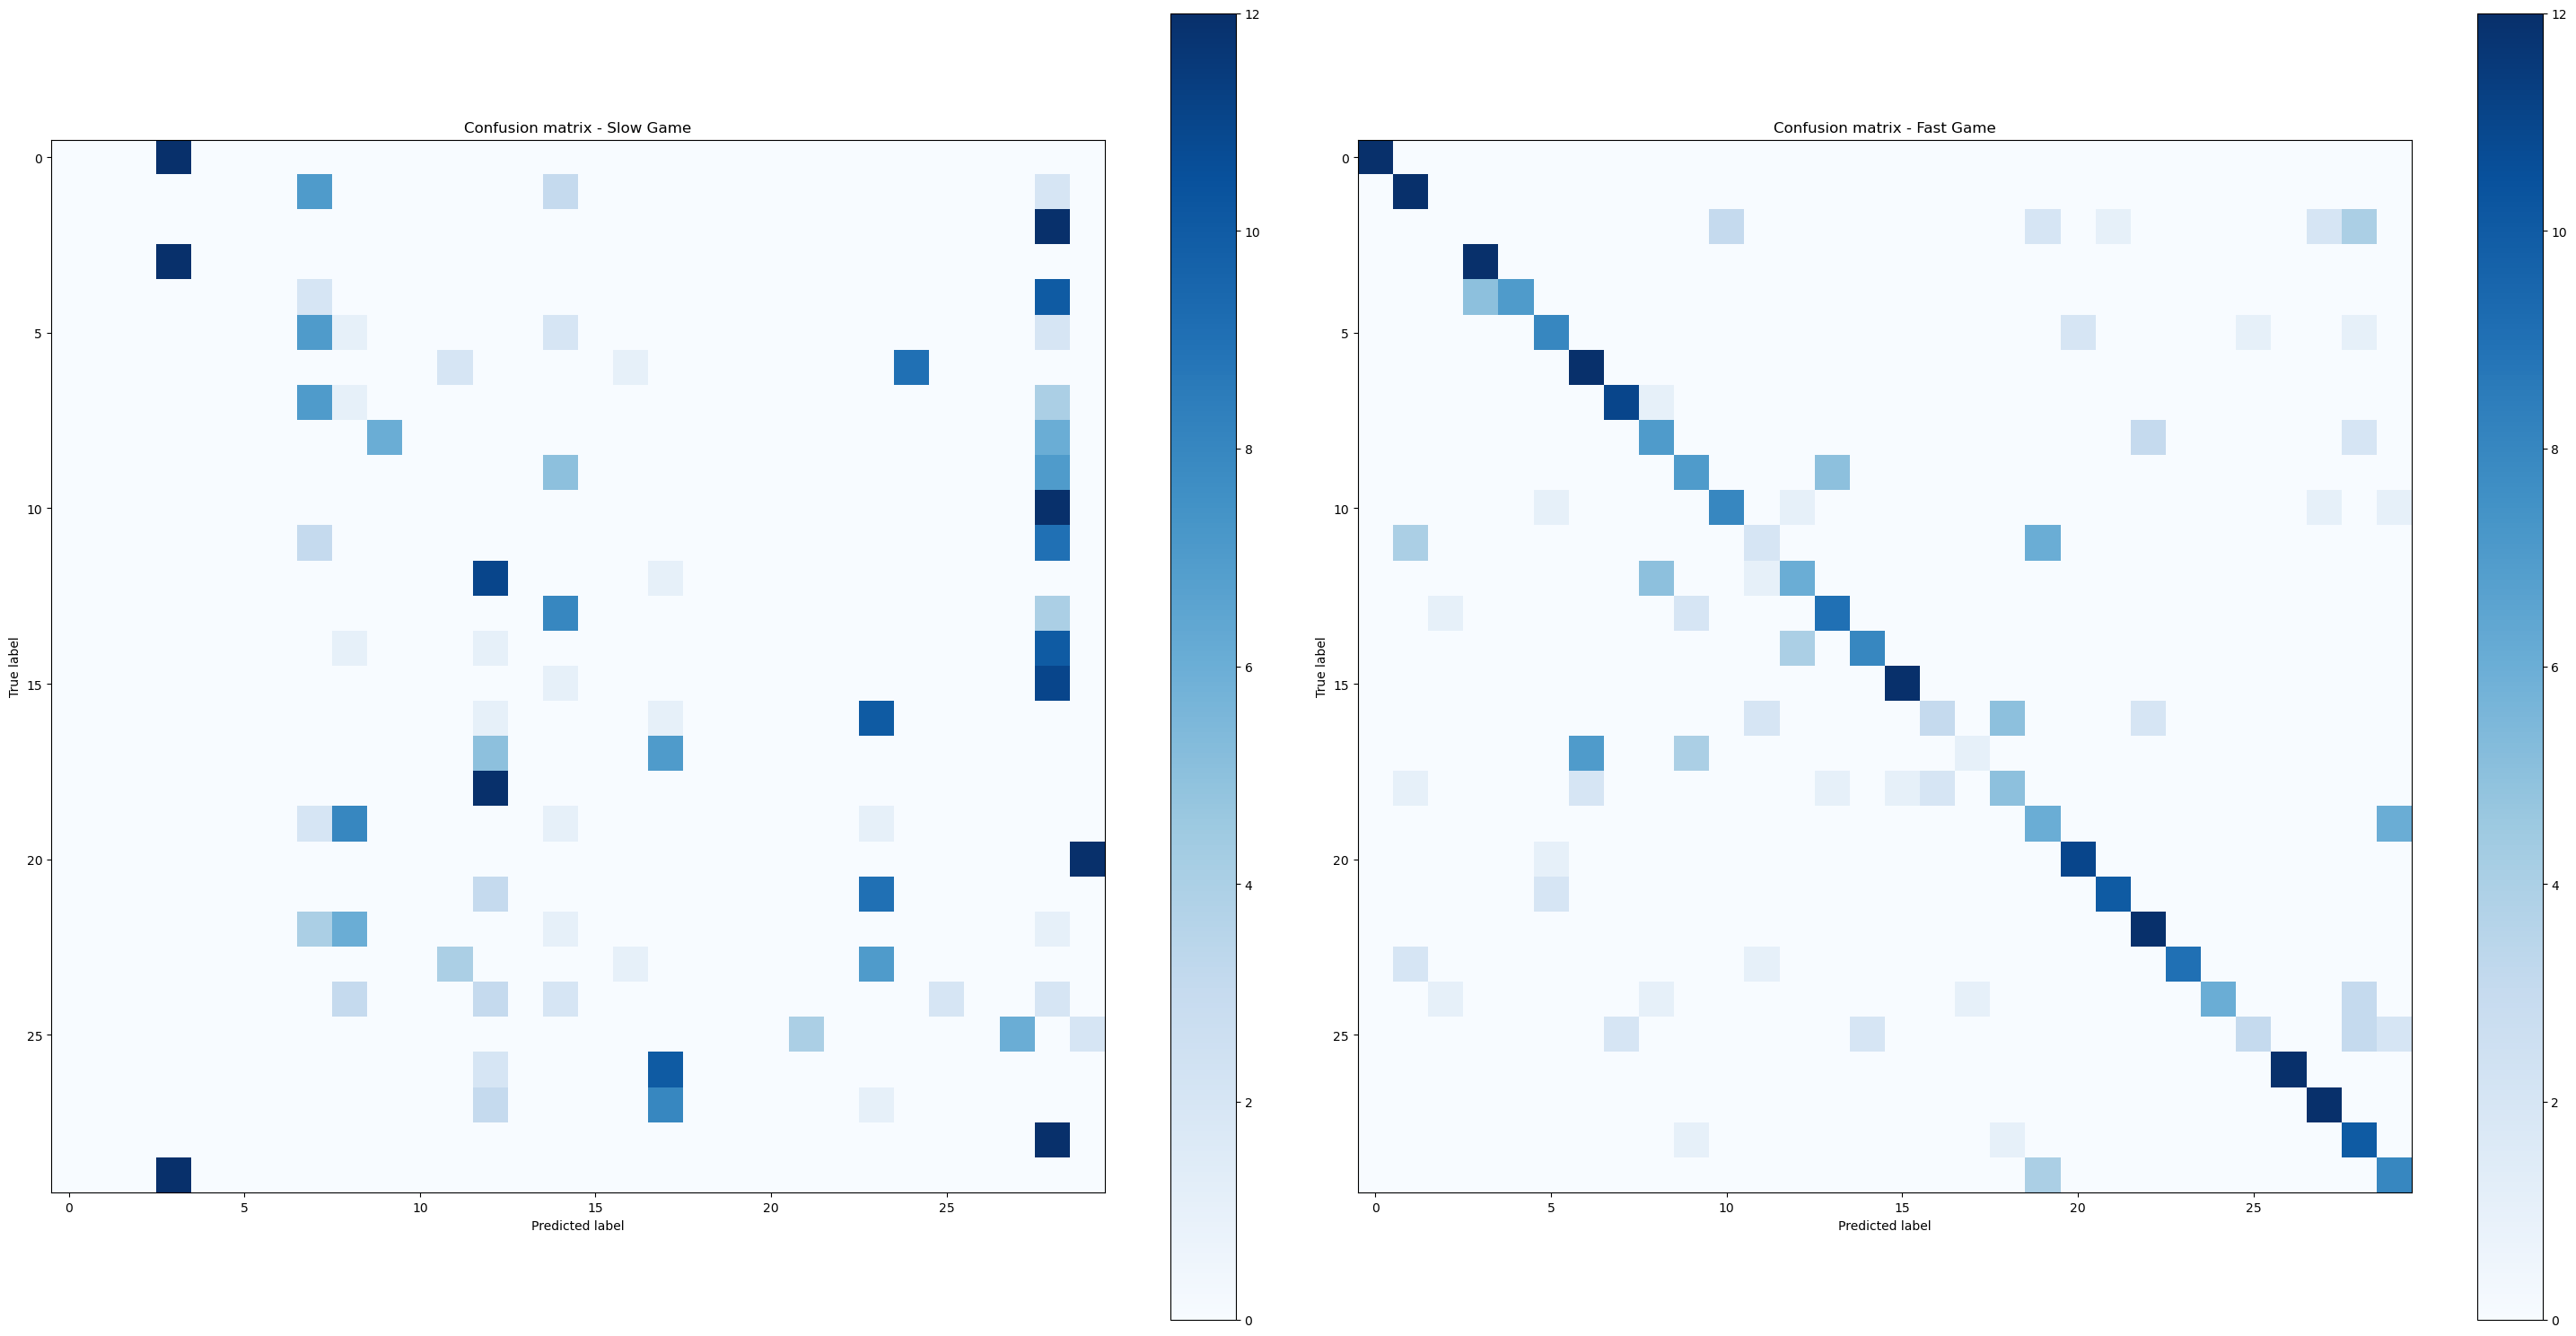

In [36]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

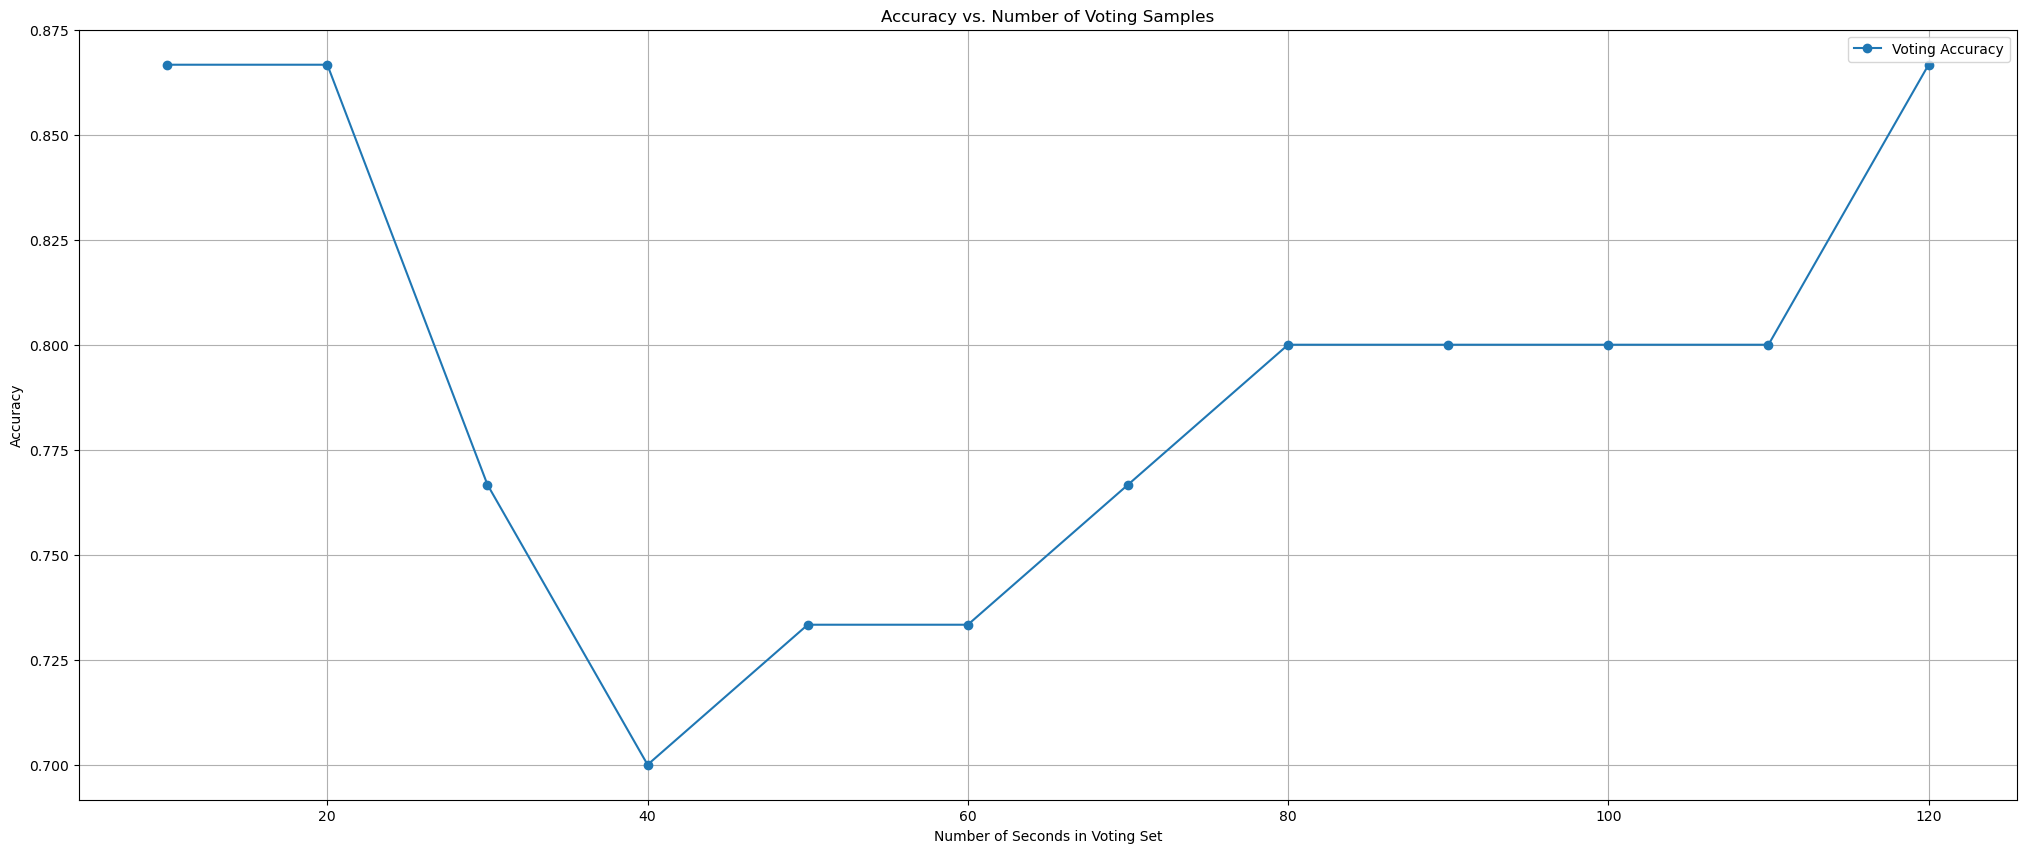


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.866667
1,20,0.866667
2,30,0.766667
3,40,0.700000
4,50,0.733333
5,60,0.733333
6,70,0.766667
7,80,0.800000
8,90,0.800000
9,100,0.800000


In [37]:
evaluator.plot_accuracy_by_vote(best_model_fast, fX_test, fy_test, increment=1)

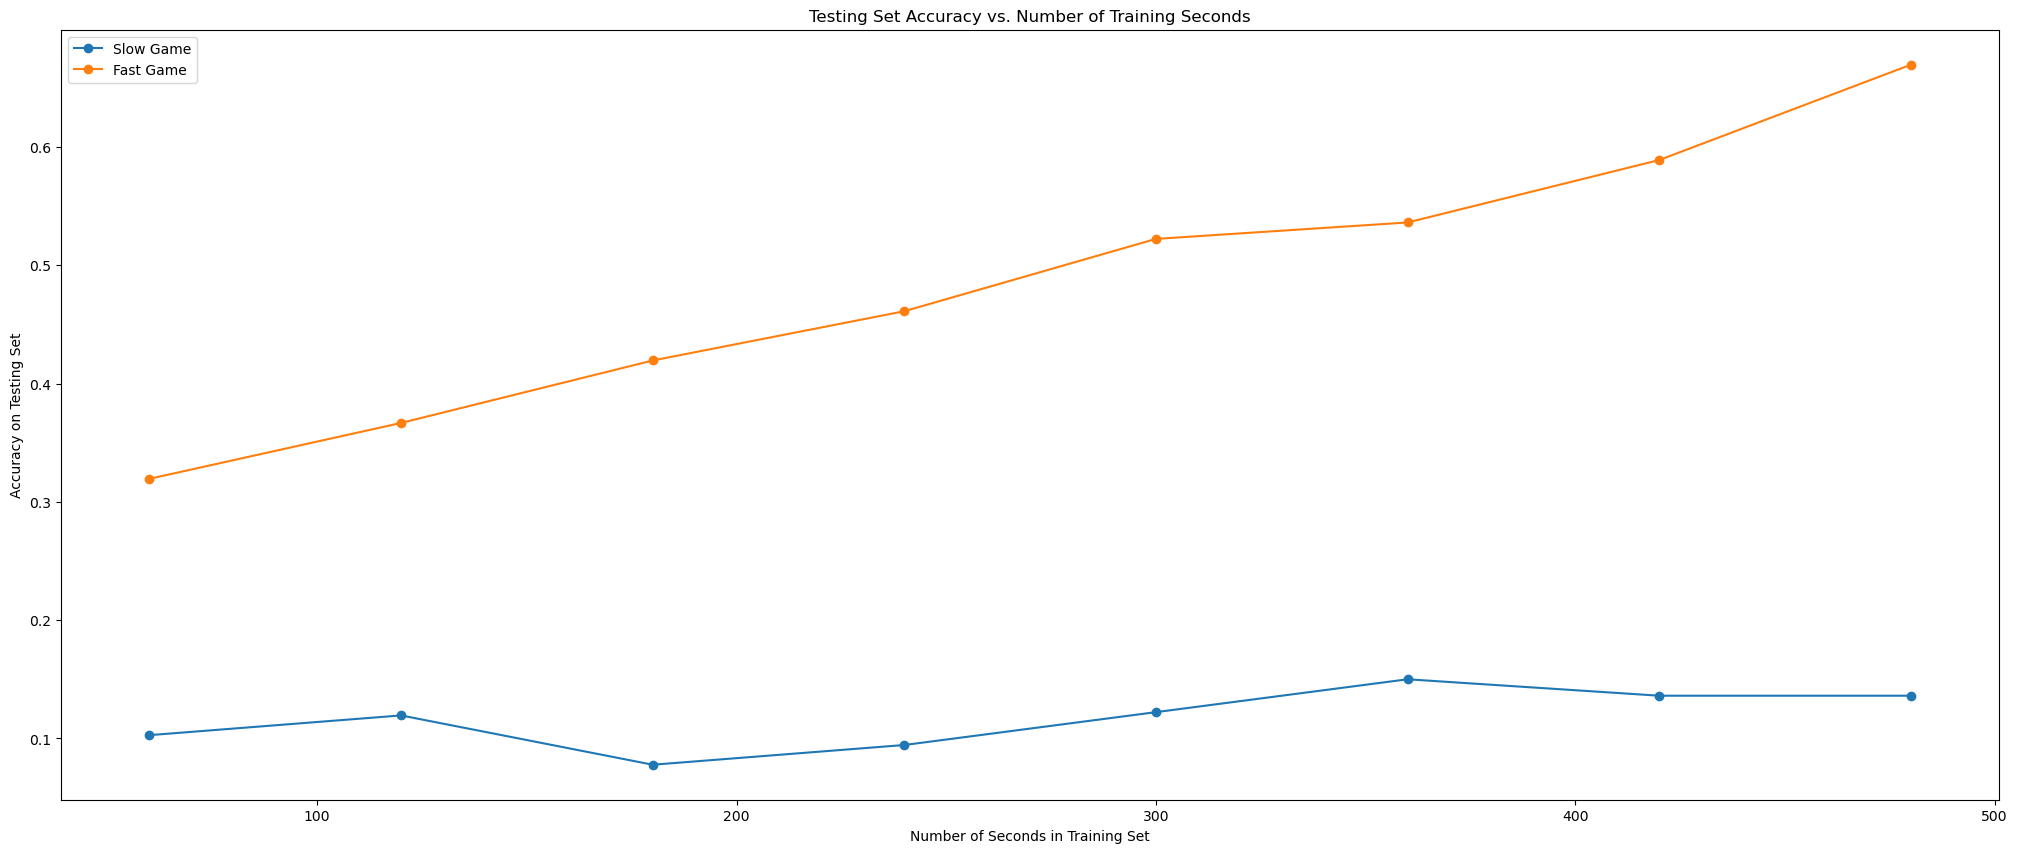


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.102778,0.319444
1,120,0.119444,0.366667
2,180,0.077778,0.419444
3,240,0.094444,0.461111
4,300,0.122222,0.522222
5,360,0.150000,0.536111
6,420,0.136111,0.588889
7,480,0.136111,0.669444


In [40]:
evaluator.accuracy_over_time(fX, fy,best_model_fast_name, range(1,9), X_test, y_test, fX_test, fy_test)

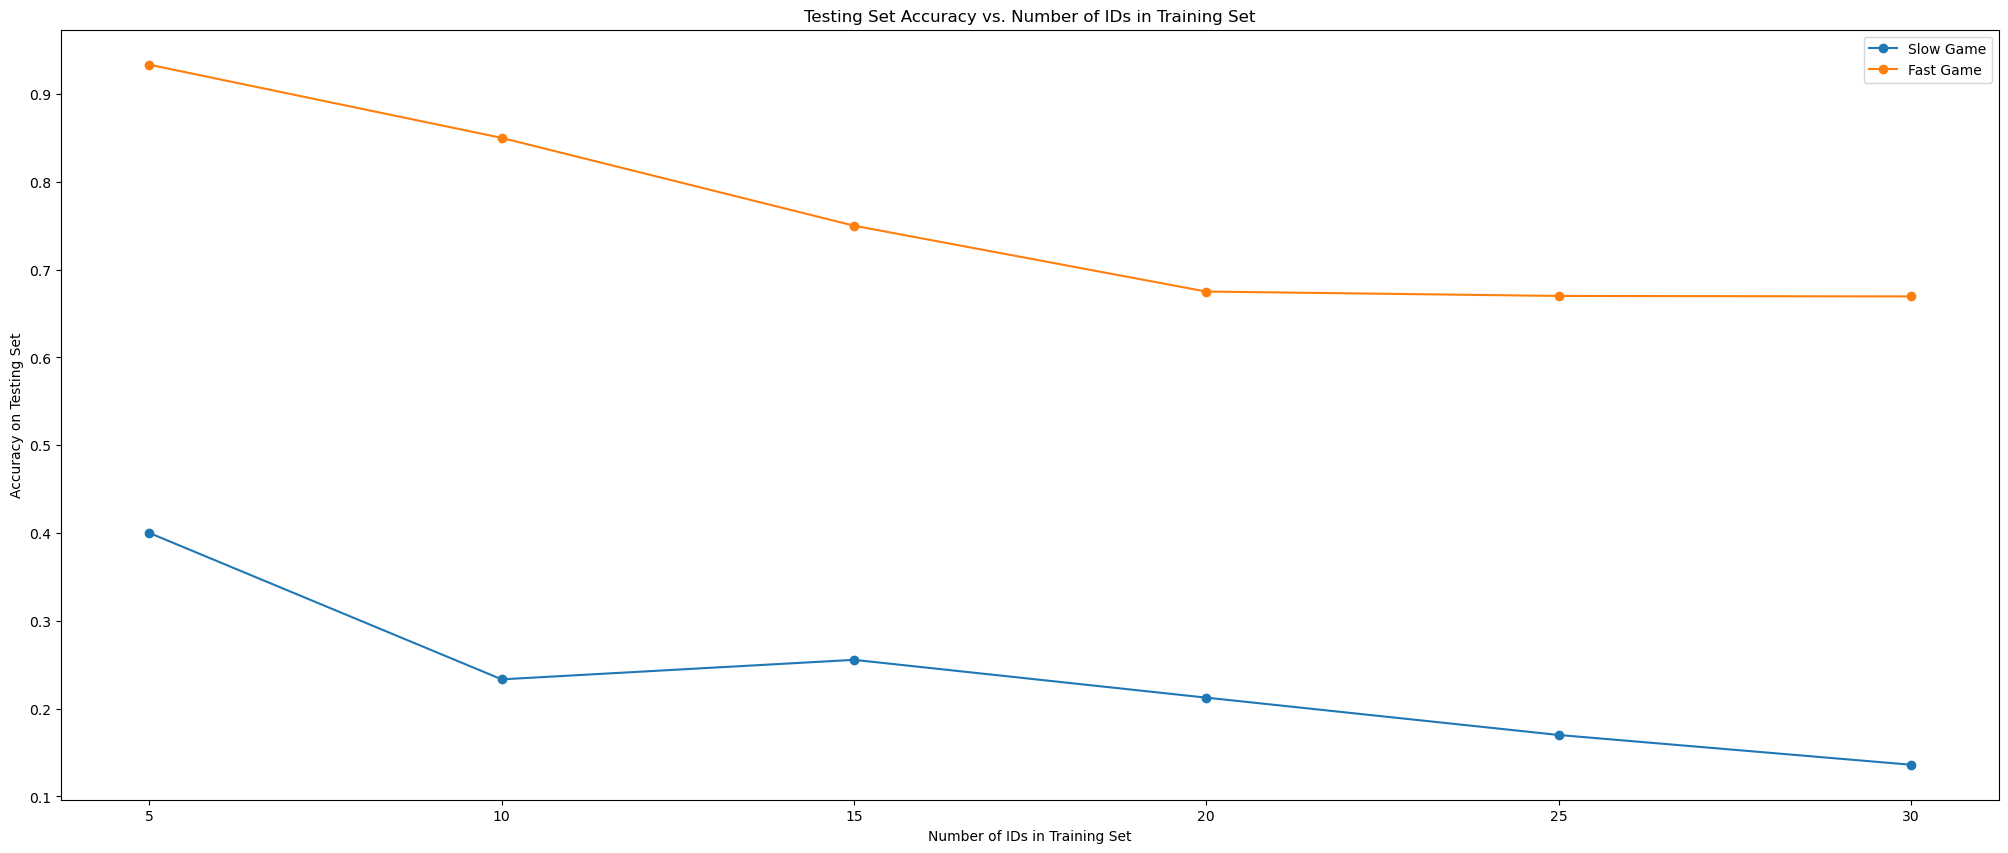


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.400000,0.933333
1,10,0.233333,0.850000
2,15,0.255556,0.750000
3,20,0.212500,0.675000
4,25,0.170000,0.670000
5,30,0.136111,0.669444


In [41]:
evaluator.accuracy_over_ids(fX_train, fy_train,best_model_fast_name, X_test, y_test,fX_test, fy_test)